# DTW Vowel Recognition (MFCC-39)


In [1]:
%pip install numpy scipy matplotlib librosa python_speech_features fastdtw


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports & globals
import os, re, json, math, itertools, random
from typing import List, Tuple, Dict, Any, Optional
from dataclasses import dataclass
from pathlib import Path
import csv

import numpy as np
import matplotlib.pyplot as plt

try:
    import librosa
    import librosa.display
except Exception as e:
    print("librosa not available yet:", e)

try:
    from python_speech_features import mfcc, delta, logfbank
except Exception as e:
    print("python_speech_features not available yet:", e)

# Reproducibility
random.seed(42)
np.random.seed(42)

# Default vowels dictionary
VOWELS = ["a", "i", "u", "e", "o"]

# Data folders
TEMPLATES_DIR = "templates_us"
TEST_DIR = "templates_other"
SR = 16000  


## Class: `VowelRecognitionDTW`

In [3]:
import numpy as np
import librosa
from python_speech_features import mfcc, delta
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import os
from collections import defaultdict
from scipy.signal import medfilt
from scipy.linalg import inv, det

class VowelRecognitionDTW:
    def __init__(self, sample_rate=16000, use_vad=True, normalize=True, n_segments=3):
        """
        Sistem pengenalan vokal menggunakan DTW dan MFCC 39 dimensi dengan Generalized Template
        
        Parameters:
        - sample_rate: sampling rate audio (default 16000 Hz)
        - use_vad: gunakan Voice Activity Detection untuk membuang silence
        - normalize: normalisasi fitur MFCC
        - n_segments: jumlah segment untuk generalized template
        """
        self.sample_rate = sample_rate
        self.use_vad = use_vad
        self.normalize = normalize
        self.n_segments = n_segments
        self.templates = {}  # {vowel: {person_id: [list of mfcc_features]}}
        self.generalized_templates = {}  # {vowel: {'means': [], 'covariances': []}}
        self.vowels = ['a', 'i', 'u', 'e', 'o']
        
    def voice_activity_detection(self, audio, top_db=20):
        """
        Deteksi bagian audio yang mengandung suara (bukan silence)
        Membuang bagian awal dan akhir yang hening
        """
        intervals = librosa.effects.split(audio, top_db=top_db)
        
        if len(intervals) == 0:
            return audio
        
        start = intervals[0][0]
        end = intervals[-1][1]
        
        return audio[start:end]
    
    def extract_mfcc_39(self, audio_path):
        """
        Ekstraksi fitur MFCC 39 dimensi dengan preprocessing yang lebih baik
        """
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)
        
        audio = librosa.effects.preemphasis(audio)
        
        if self.use_vad:
            audio = self.voice_activity_detection(audio, top_db=20)
        
        audio = audio / (np.max(np.abs(audio)) + 1e-6)
        
        mfcc_features = mfcc(
            audio, 
            samplerate=sr, 
            numcep=13,
            nfilt=26, 
            nfft=512,
            winstep=0.01,
            winlen=0.025,
            preemph=0,  
            ceplifter=22,
            appendEnergy=True
        )
        
        for i in range(mfcc_features.shape[1]):
            mfcc_features[:, i] = medfilt(mfcc_features[:, i], kernel_size=3)
        
        delta_features = delta(mfcc_features, 2)
        delta2_features = delta(delta_features, 2)
        
        features_39 = np.hstack([mfcc_features, delta_features, delta2_features])
        
        if self.normalize:
            features_39 = (features_39 - np.mean(features_39, axis=0)) / (np.std(features_39, axis=0) + 1e-6)
        
        return features_39
    
    def segment_features(self, features):
        """
        Membagi fitur menjadi n_segments menggunakan uniform segmentation
        """
        n_frames = features.shape[0]
        segment_size = n_frames // self.n_segments
        segments = []
        
        for i in range(self.n_segments):
            start_idx = i * segment_size
            if i == self.n_segments - 1:
                end_idx = n_frames
            else:
                end_idx = (i + 1) * segment_size
            
            segment = features[start_idx:end_idx]
            segments.append(segment)
        
        return segments
    
    def compute_segment_statistics(self, segments_list):
        """
        Menghitung mean dan covariance untuk setiap segment dari multiple templates
        segments_list: list of segments from different templates
        """
        means = []
        covariances = []
        
        for segment_idx in range(self.n_segments):
            all_vectors = []
            
            for segments in segments_list:
                if segment_idx < len(segments):
                    all_vectors.extend(segments[segment_idx])
            
            if len(all_vectors) > 0:
                all_vectors = np.array(all_vectors)
                
                mean_vector = np.mean(all_vectors, axis=0)
                
                if all_vectors.shape[0] > 1:
                    cov_matrix = np.cov(all_vectors.T)
                    if cov_matrix.ndim == 0:
                        cov_matrix = np.eye(all_vectors.shape[1]) * cov_matrix
                    elif cov_matrix.shape[0] == 1:
                        cov_matrix = np.eye(all_vectors.shape[1]) * cov_matrix[0, 0]
                else:
                    cov_matrix = np.eye(all_vectors.shape[1]) * 0.01
                
                cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
                
                means.append(mean_vector)
                covariances.append(cov_matrix)
        
        return means, covariances
    
    def mahalanobis_distance(self, x, mean, cov):
        """
        Menghitung Mahalanobis distance
        """
        try:
            cov_inv = inv(cov)
            diff = x - mean
            distance = np.sqrt(np.dot(np.dot(diff, cov_inv), diff.T))
            return distance
        except:
            return euclidean(x, mean)
    
    def gaussian_log_likelihood(self, x, mean, cov):
        """
        Menghitung negative Gaussian log likelihood
        """
        try:
            cov_inv = inv(cov)
            det_cov = det(cov)
            
            if det_cov <= 0:
                det_cov = 1e-6
            
            diff = x - mean
            mahal_dist = np.dot(np.dot(diff, cov_inv), diff.T)
            
            log_likelihood = 0.5 * (len(mean) * np.log(2 * np.pi) + np.log(det_cov) + mahal_dist)
            
            return log_likelihood
        except:
            return euclidean(x, mean)
    
    def dtw_distance_generalized(self, test_features, means, covariances):
        """
        Menghitung jarak DTW menggunakan generalized template dengan Gaussian distribution
        """
        test_segments = self.segment_features(test_features)
        
        if len(means) != len(test_segments):
            min_segments = min(len(means), len(test_segments))
            means = means[:min_segments]
            covariances = covariances[:min_segments]
            test_segments = test_segments[:min_segments]
        
        total_distance = 0
        path_length = 0
        
        for i, (test_segment, mean, cov) in enumerate(zip(test_segments, means, covariances)):
            segment_distances = []
            
            for test_vector in test_segment:
                distance = self.gaussian_log_likelihood(test_vector, mean, cov)
                segment_distances.append(distance)
            
            if len(segment_distances) > 0:
                avg_segment_distance = np.mean(segment_distances)
                total_distance += avg_segment_distance
                path_length += 1
        
        if path_length > 0:
            normalized_distance = total_distance / path_length
        else:
            normalized_distance = float('inf')
        
        return normalized_distance
    
    def add_template(self, vowel, person_id, audio_path):
        """
        Menambahkan template ke dictionary
        """
        if vowel not in self.vowels:
            raise ValueError(f"Vokal harus salah satu dari {self.vowels}")
        
        features = self.extract_mfcc_39(audio_path)
        
        if vowel not in self.templates:
            self.templates[vowel] = {}
        
        if person_id not in self.templates[vowel]:
            self.templates[vowel][person_id] = []
        
        self.templates[vowel][person_id].append(features)
        print(f"Template ditambahkan: {vowel} dari {person_id} ({len(self.templates[vowel][person_id])} file)")
    
    def build_generalized_templates(self):
        """
        Membangun generalized templates dari semua templates yang ada
        """
        print("\n=== BUILDING GENERALIZED TEMPLATES ===")
        
        for vowel in self.vowels:
            if vowel not in self.templates:
                continue
            
            print(f"Building generalized template for vowel: {vowel}")
            
            all_segments = []
            
            for person_id, template_features_list in self.templates[vowel].items():
                for template_features in template_features_list:
                    segments = self.segment_features(template_features)
                    all_segments.append(segments)
            
            if len(all_segments) > 0:
                means, covariances = self.compute_segment_statistics(all_segments)
                
                self.generalized_templates[vowel] = {
                    'means': means,
                    'covariances': covariances
                }
                
                print(f"  - Created {len(means)} segments with mean and covariance parameters")
            else:
                print(f"  - No templates found for vowel {vowel}")
        
        print("Generalized templates built successfully!")
    
    def recognize(self, audio_path, template_person_id=None):
        """
        Mengenali vokal dari file audio menggunakan generalized templates
        """
        if not self.generalized_templates:
            print("Building generalized templates...")
            self.build_generalized_templates()
        
        test_features = self.extract_mfcc_39(audio_path)
        
        min_distance = float('inf')
        recognized_vowel = None
        all_distances = {}
        
        for vowel in self.vowels:
            if vowel not in self.generalized_templates:
                continue
            
            means = self.generalized_templates[vowel]['means']
            covariances = self.generalized_templates[vowel]['covariances']
            
            if len(means) > 0 and len(covariances) > 0:
                distance = self.dtw_distance_generalized(test_features, means, covariances)
                all_distances[vowel] = distance
                
                if distance < min_distance:
                    min_distance = distance
                    recognized_vowel = vowel
        
        return recognized_vowel, min_distance, all_distances, all_distances

    def print_detailed_prediction(self, audio_path, true_vowel, test_person_id, recognized_vowel, distance, final_vowel_distances, is_correct, scenario=""):
        """
        Print detailed prediction information
        """
        filename = os.path.basename(audio_path)
        status = "CORRECT" if is_correct else "WRONG"
        
        print(f"\n  Test: {filename}")
        print(f"    Person: {test_person_id}")
        print(f"    Actual: {true_vowel} | Predicted: {recognized_vowel} | {status}")
        print(f"    Best Distance: {distance:.4f}")
        
        print(f"    All distances:")
        sorted_distances = sorted(final_vowel_distances.items(), key=lambda x: x[1])
        for vowel, dist in sorted_distances:
            marker = " <- CHOSEN" if vowel == recognized_vowel else ""
            correct_marker = " (CORRECT)" if vowel == true_vowel else ""
            print(f"      {vowel}: {dist:.4f}{marker}{correct_marker}")
    
    def test_closed_scenario(self, test_data):
        """
        Skenario Closed
        """
        correct = 0
        total = 0
        results = []
        
        print(f"\n--- DETAILED CLOSED SCENARIO RESULTS ---")
        
        for audio_path, true_vowel, test_person_id in test_data:
            recognized_vowel, distance, all_distances, final_vowel_distances = self.recognize(audio_path)
            
            is_correct = (recognized_vowel == true_vowel)
            if is_correct:
                correct += 1
            total += 1
            
            self.print_detailed_prediction(
                audio_path, true_vowel, test_person_id, 
                recognized_vowel, distance, final_vowel_distances, 
                is_correct, "CLOSED"
            )
            
            results.append({
                'audio': audio_path,
                'true': true_vowel,
                'predicted': recognized_vowel,
                'person': test_person_id,
                'correct': is_correct,
                'distance': distance,
                'final_vowel_distances': final_vowel_distances
            })
        
        accuracy = (correct / total) * 100 if total > 0 else 0
        print(f"\n  CLOSED SCENARIO SUMMARY: {correct}/{total} correct = {accuracy:.2f}%")
        return accuracy, results
    
    def test_open_scenario(self, test_data, template_person_ids):
        """
        Skenario Open
        """
        correct = 0
        total = 0
        results = []
        
        original_templates = self.templates.copy()
        original_generalized = self.generalized_templates.copy()
        
        filtered_templates = {}
        for vowel in self.templates:
            filtered_templates[vowel] = {
                pid: feat for pid, feat in self.templates[vowel].items() 
                if pid in template_person_ids
            }
        
        self.templates = filtered_templates
        self.generalized_templates = {}
        self.build_generalized_templates()
        
        print(f"\n--- DETAILED OPEN SCENARIO RESULTS ---")
        print(f"Using templates from: {template_person_ids}")
        
        for audio_path, true_vowel, test_person_id in test_data:
            recognized_vowel, distance, all_distances, final_vowel_distances = self.recognize(audio_path)
            
            is_correct = (recognized_vowel == true_vowel)
            if is_correct:
                correct += 1
            total += 1
            
            self.print_detailed_prediction(
                audio_path, true_vowel, test_person_id, 
                recognized_vowel, distance, final_vowel_distances, 
                is_correct, "OPEN"
            )
            
            results.append({
                'audio': audio_path,
                'true': true_vowel,
                'predicted': recognized_vowel,
                'person': test_person_id,
                'correct': is_correct,
                'distance': distance,
                'final_vowel_distances': final_vowel_distances
            })
        
        self.templates = original_templates
        self.generalized_templates = original_generalized
        
        accuracy = (correct / total) * 100 if total > 0 else 0
        print(f"\n  OPEN SCENARIO SUMMARY: {correct}/{total} correct = {accuracy:.2f}%")
        return accuracy, results
    
    def evaluate_all_scenarios(self, test_data_us, test_data_other):
        """
        Evaluasi lengkap: closed, open, dan rata-rata
        """
        all_persons = list(set([person_id for _, _, person_id in test_data_us]))
        results_summary = {}
        
        for template_person in all_persons:
            print(f"\n{'='*60}")
            print(f"=== EVALUATION WITH TEMPLATES FROM {template_person.upper()} ===")
            print(f"{'='*60}")
            
            print(f"\nTotal test files (templates_us): {len(test_data_us)}")
            print(f"Total test files (templates_other): {len(test_data_other)}")
            
            print(f"\n[CLOSED SCENARIO] (all templates vs test from templates_us)")
            closed_acc, closed_results = self.test_closed_scenario(test_data_us)
            
            open_test_data = test_data_other
            
            print(f"\n[OPEN SCENARIO] (templates from {template_person} vs test from templates_other)")
            print(f"Test files: {len(open_test_data)}")
            
            open_acc, open_results = self.test_open_scenario(
                open_test_data, 
                [template_person]
            )
            
            avg_acc = (closed_acc + open_acc) / 2
            
            results_summary[template_person] = {
                'closed_accuracy': closed_acc,
                'open_accuracy': open_acc,
                'average_accuracy': avg_acc,
                'closed_results': closed_results,
                'open_results': open_results
            }
            
            print(f"\n--- SUMMARY FOR {template_person.upper()} ---")
            print(f"  Closed Accuracy: {closed_acc:.2f}%")
            print(f"  Open Accuracy: {open_acc:.2f}%")
            print(f"  Average Accuracy: {avg_acc:.2f}%")
        
        overall_closed = np.mean([r['closed_accuracy'] for r in results_summary.values()])
        overall_open = np.mean([r['open_accuracy'] for r in results_summary.values()])
        overall_avg = np.mean([r['average_accuracy'] for r in results_summary.values()])
        
        print(f"\n{'='*60}")
        print(f"=== OVERALL RESULTS ACROSS ALL TEMPLATE PERSONS ===")
        print(f"{'='*60}")
        print(f"Overall Closed Accuracy: {overall_closed:.2f}%")
        print(f"Overall Open Accuracy: {overall_open:.2f}%")
        print(f"Overall Average Accuracy: {overall_avg:.2f}%")
        
        results_summary['overall'] = {
            'closed_accuracy': overall_closed,
            'open_accuracy': overall_open,
            'average_accuracy': overall_avg
        }
        
        return results_summary
    
    def save_predictions_to_csv(self, results, filename):
        """
        Menyimpan hasil prediksi ke file CSV
        """
        import csv
        
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['file', 'path', 'person', 'true_vowel', 'pred_vowel', 
                         'dist_a', 'dist_e', 'dist_i', 'dist_o', 'dist_u']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            writer.writeheader()
            for result in results:
                row = {
                    'file': os.path.basename(result['audio']),
                    'path': result['audio'],
                    'person': result['person'],
                    'true_vowel': result['true'],
                    'pred_vowel': result['predicted'],
                    'dist_a': result['final_vowel_distances'].get('a', 0),
                    'dist_e': result['final_vowel_distances'].get('e', 0),
                    'dist_i': result['final_vowel_distances'].get('i', 0),
                    'dist_o': result['final_vowel_distances'].get('o', 0),
                    'dist_u': result['final_vowel_distances'].get('u', 0)
                }
                writer.writerow(row)
        
        print(f"Predictions saved to: {filename}")

    def print_confusion_matrix(self, results):
        """
        Print confusion matrix untuk analisis error
        """
        from collections import Counter
        
        confusion = defaultdict(lambda: defaultdict(int))
        
        for result in results:
            true_label = result['true']
            pred_label = result['predicted']
            confusion[true_label][pred_label] += 1
        
        print("\n=== CONFUSION MATRIX ===")
        print(f"{'':5}", end='')
        for vowel in self.vowels:
            print(f"{vowel:5}", end='')
        print()
        
        for true_vowel in self.vowels:
            print(f"{true_vowel:5}", end='')
            for pred_vowel in self.vowels:
                count = confusion[true_vowel][pred_vowel]
                print(f"{count:5}", end='')
            print()

## Class: `VowelDTWVisualizer`

In [4]:
from __future__ import annotations

import os 
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import librosa
import librosa.display
from scipy.spatial.distance import cdist
from scipy.linalg import inv
import seaborn as sns

class VowelDTWVisualizer:
    def __init__(self, recognizer):
        self.recognizer = recognizer

    def _ensure_dir_for(self, path: str | None):
        if not path:
            return
        d = os.path.dirname(path)
        if d and not os.path.exists(d):
            os.makedirs(d, exist_ok=True)

    def plot_waveform_with_vad(self, audio_path, top_db=20, save_path=None):
        y, sr = librosa.load(audio_path, sr=self.recognizer.sample_rate)
        y = librosa.effects.preemphasis(y)
        intervals = librosa.effects.split(y, top_db=top_db)

        plt.figure(figsize=(12, 3))
        times = np.arange(len(y))/sr
        plt.plot(times, y, linewidth=0.8, label='Sinyal audio')
        for i, (s, e) in enumerate(intervals):
            label = 'Aktivitas suara' if i == 0 else ''
            plt.axvspan(s/sr, e/sr, alpha=0.2, color='green', label=label)
        plt.title(f"Gelombang + interval VAD ({os.path.basename(audio_path)})")
        plt.xlabel("Waktu (detik)")
        plt.ylabel("Amplitudo")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_mfcc39_with_segments(self, audio_path, save_prefix=None):
        feats = self.recognizer.extract_mfcc_39(audio_path)
        segments = self.recognizer.segment_features(feats)
        
        mfcc_13   = feats[:, :13].T
        delta_13  = feats[:, 13:26].T
        delta2_13 = feats[:, 26:39].T

        def _show_with_segments(mat, title, segments_data):
            plt.figure(figsize=(12, 4))
            librosa.display.specshow(mat, x_axis='time', cmap='viridis')
            plt.title(f"{title} - {os.path.basename(audio_path)}")
            plt.colorbar(format="%+0.2f")
            
            n_frames = mat.shape[1]
            segment_size = n_frames // self.recognizer.n_segments
            for i in range(1, self.recognizer.n_segments):
                boundary = i * segment_size
                plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.7, linewidth=2)
            
            for i in range(self.recognizer.n_segments):
                start_x = i * segment_size
                end_x = (i + 1) * segment_size if i < self.recognizer.n_segments - 1 else n_frames
                center_x = (start_x + end_x) / 2
                plt.text(center_x, mat.shape[0] - 1, f'Seg {i+1}', 
                        ha='center', va='top', color='white', fontweight='bold')
            
            plt.tight_layout()
            if save_prefix:
                filename = f"{save_prefix}_{title.replace(' ', '_').lower()}.png"
                self._ensure_dir_for(filename)
                plt.savefig(filename, dpi=150)
            plt.show()

        _show_with_segments(mfcc_13, "MFCC (13)", segments)
        _show_with_segments(delta_13, "Delta (13)", segments)
        _show_with_segments(delta2_13, "Delta-Delta (13)", segments)

    def plot_mfcc39(self, audio_path, save_prefix=None):
        self.plot_mfcc39_with_segments(audio_path, save_prefix)

    def plot_vowel_distances_bar(self, final_vowel_distances: dict, true_vowel=None, 
                                title="Jarak final per vokal", save_path=None):
        vowels = list(final_vowel_distances.keys())
        vals = [final_vowel_distances[v] for v in vowels]
        colors = ['green' if v == true_vowel else 'lightblue' for v in vowels]
        
        idx = np.arange(len(vowels))
        plt.figure(figsize=(8, 4))
        bars = plt.bar(idx, vals, color=colors, edgecolor='black', linewidth=0.5)
        plt.xticks(idx, vowels)
        plt.ylabel("Jarak DTW (ternormalisasi)")
        plt.title(title)
        
        for bar, val in zip(bars, vals):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{val:.3f}', ha='center', va='bottom')
        
        if true_vowel:
            plt.text(0.02, 0.95, f'Vokal benar: {true_vowel}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_generalized_templates(self, vowel, save_path=None):
        if vowel not in self.recognizer.generalized_templates:
            print(f"Template umum tidak ditemukan untuk vokal '{vowel}'")
            return
        
        template = self.recognizer.generalized_templates[vowel]
        means = template['means']
        covariances = template['covariances']
        
        n_segments = len(means)
        fig, axes = plt.subplots(2, n_segments, figsize=(4*n_segments, 6))
        
        if n_segments == 1:
            axes = axes.reshape(2, 1)
        
        for i, (mean, cov) in enumerate(zip(means, covariances)):
            axes[0, i].bar(range(len(mean)), mean)
            axes[0, i].set_title(f'Segmen {i+1} - Rata-rata')
            axes[0, i].set_xlabel('Fitur MFCC')
            axes[0, i].set_ylabel('Nilai')
            axes[0, i].grid(True, alpha=0.3)
            
            im = axes[1, i].imshow(cov, cmap='coolwarm', aspect='auto')
            axes[1, i].set_title(f'Segmen {i+1} - Kovarians')
            axes[1, i].set_xlabel('Fitur')
            axes[1, i].set_ylabel('Fitur')
            plt.colorbar(im, ax=axes[1, i])
        
        plt.suptitle(f'Template Umum untuk Vokal: {vowel.upper()}')
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_segment_distances(self, audio_path, vowel, save_path=None):
        if vowel not in self.recognizer.generalized_templates:
            print(f"Template umum tidak ditemukan untuk vokal '{vowel}'")
            return
        
        test_features = self.recognizer.extract_mfcc_39(audio_path)
        test_segments = self.recognizer.segment_features(test_features)
        
        template = self.recognizer.generalized_templates[vowel]
        means = template['means']
        covariances = template['covariances']
        
        segment_distances = []
        for i, (test_segment, mean, cov) in enumerate(zip(test_segments, means, covariances)):
            distances = []
            for test_vector in test_segment:
                dist = self.recognizer.gaussian_log_likelihood(test_vector, mean, cov)
                distances.append(dist)
            segment_distances.append(distances)
        
        plt.figure(figsize=(12, 4))
        for i, distances in enumerate(segment_distances):
            plt.subplot(1, len(segment_distances), i+1)
            plt.plot(distances, marker='o', markersize=3)
            plt.title(f'Segmen {i+1}')
            plt.xlabel('Frame')
            plt.ylabel('Log-likelihood')
            plt.grid(True, alpha=0.3)
            plt.text(0.5, 0.95, f'Rata-rata: {np.mean(distances):.3f}', 
                    transform=plt.gca().transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle(f'Jarak per segmen: {os.path.basename(audio_path)} vs {vowel.upper()}')
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_dtw_alignment(self, template_features, test_features, title="Penyelarasan DTW", save_path=None):
        A = template_features[:, :13]
        B = test_features[:, :13]
        D = cdist(A, B, metric='euclidean')
        C, wp = librosa.sequence.dtw(C=D)  

        plt.figure(figsize=(8, 6))
        plt.imshow(D.T, origin='lower', aspect='auto', cmap='hot')
        path_i = [p[0] for p in wp]
        path_j = [p[1] for p in wp]
        plt.plot(path_i, path_j, color='cyan', linewidth=2, label='Jalur warping')
        plt.xlabel("Frame template")
        plt.ylabel("Frame uji")
        plt.title(f"{title}\n(Matriks biaya + jalur warping)")
        plt.colorbar(label='Jarak')
        plt.legend()
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_confusion_heatmap(self, results, vowels=('a','i','u','e','o'), 
                              title="Matriks Konfusi", save_path=None):
        idx = {v:i for i,v in enumerate(vowels)}
        cm = np.zeros((len(vowels), len(vowels)), dtype=int)
        for r in results:
            if r['true'] in idx and r['predicted'] in idx:
                cm[idx[r['true']], idx[r['predicted']]] += 1

        class_acc = []
        for i in range(len(vowels)):
            if cm[i].sum() > 0:
                acc = cm[i, i] / cm[i].sum() * 100
            else:
                acc = 0
            class_acc.append(acc)

        plt.figure(figsize=(7, 5.5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=vowels, yticklabels=vowels,
                   square=True, cbar_kws={'label': 'Jumlah'})
        plt.title(f"{title}\nAkurasi Keseluruhan: {np.trace(cm)/np.sum(cm)*100:.1f}%")
        plt.xlabel("Prediksi")
        plt.ylabel("Aktual")
        
        for i, acc in enumerate(class_acc):
            plt.text(len(vowels) + 0.1, i + 0.5, f'{acc:.1f}%', 
                    ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_all_vowel_distances(self, audio_path, save_path=None):
        """Plot jarak ke semua template vokal untuk audio uji"""
        _, _, _, all_distances = self.recognizer.recognize(audio_path)
        
        vowels = list(all_distances.keys())
        distances = [all_distances[v] for v in vowels]
        
        plt.figure(figsize=(10, 5))
        colors = plt.cm.viridis(np.linspace(0, 1, len(vowels)))
        bars = plt.bar(vowels, distances, color=colors, edgecolor='black', linewidth=0.5)
        
        min_idx = np.argmin(distances)
        bars[min_idx].set_color('red')
        bars[min_idx].set_edgecolor('darkred')
        bars[min_idx].set_linewidth(2)
        
        plt.ylabel('Jarak DTW (Log-likelihood)')
        plt.title(f'Jarak ke Semua Template Vokal\n{os.path.basename(audio_path)}')
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, distances):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.text(0.02, 0.95, f'Prediksi: {vowels[min_idx].upper()}', 
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.8, edgecolor='darkred'),
                color='white', fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

    def plot_template_distribution(self, save_path=None):
        """Visualisasi distribusi template antar vokal dan orang"""
        if not self.recognizer.templates:
            print("Tidak ada template yang tersedia untuk divisualisasikan")
            return
        
        vowels = []
        persons = []
        counts = []
        
        for vowel, person_dict in self.recognizer.templates.items():
            for person, template_list in person_dict.items():
                vowels.append(vowel)
                persons.append(person)
                counts.append(len(template_list))
        
        unique_vowels = sorted(list(set(vowels)))
        unique_persons = sorted(list(set(persons)))
        
        matrix = np.zeros((len(unique_persons), len(unique_vowels)))
        for v, p, c in zip(vowels, persons, counts):
            v_idx = unique_vowels.index(v)
            p_idx = unique_persons.index(p)
            matrix[p_idx, v_idx] = c
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, fmt='g', cmap='YlOrRd',
                   xticklabels=unique_vowels, yticklabels=unique_persons,
                   cbar_kws={'label': 'Jumlah template'})
        plt.title('Distribusi Template Antar Vokal dan Orang')
        plt.xlabel('Vokal')
        plt.ylabel('Orang')
        plt.tight_layout()
        if save_path:
            self._ensure_dir_for(save_path)
            plt.savefig(save_path, dpi=150)
        plt.show()

## Utilities: file scanning & feature extraction

In [5]:
def scan_person_folder(folder: str, vowels: List[str]) -> Dict[str, List[Tuple[str, int]]]:
    result: Dict[str, List[Tuple[str, int]]] = {}
    if not os.path.exists(folder):
        print(f"Folder tidak ditemukan: {folder}")
        return result

    for filename in os.listdir(folder):
        if not (filename.lower().endswith(".wav") or filename.lower().endswith(".m4a")):
            continue
        name_wo_ext = filename.rsplit(".", 1)[0]
        parts = name_wo_ext.split(" - ")
        if len(parts) < 2:
            continue

        # ekspektasi: "<person> - <vowel> <num>"
        vowel_num = parts[1].strip().split()
        if len(vowel_num) < 2:
            continue

        vowel_part = vowel_num[0].lower()
        try:
            file_num = int(re.sub(r'\D+', '', vowel_num[1]))
        except ValueError:
            print(f"Warning: Could not parse number from {filename}")
            continue

        if vowel_part in vowels:
            result.setdefault(vowel_part, []).append((os.path.join(folder, filename), file_num))

    # sort each list by num asc
    for v in list(result.keys()):
        result[v].sort(key=lambda x: x[1])
    return result


def scan_person_folder_recursive(root: str, vowels: List[str]) -> Dict[str, List[Tuple[str, int]]]:
    out: Dict[str, List[Tuple[str, int]]] = {}
    rootp = Path(root)
    if not rootp.exists():
        print(f"[WARN] Folder not found: {root}")
        return out

    for f in rootp.rglob("*"):
        if not f.is_file():
            continue
        if f.suffix.lower() not in (".wav", ".m4a"):
            continue

        base = f.stem
        if " - " not in base:
            continue

        right = base.split(" - ", 1)[1].strip()
        parts = right.split()
        if not parts:
            continue

        vtok = parts[0].lower()
        if vtok not in vowels:
            continue

        num = 0
        if len(parts) > 1:
            try:
                num = int(re.sub(r"\D+", "", parts[1]))
            except Exception:
                num = 0

        out.setdefault(vtok, []).append((str(f), num))

    for v in list(out.keys()):
        out[v].sort(key=lambda x: x[1])
    return out


def person_id_from_name(filepath: str) -> str:
    base = Path(filepath).stem
    parts = base.split(' - ')
    return parts[0].strip().lower() if parts else "unknown"


def diagnose_templates_dir(root: str, exts=(".wav", ".m4a")):
    p = Path(root)
    print("Exists:", p.exists(), "| Dir:", p.is_dir(), "| Path:", p.resolve())
    if not p.exists():
        return
    print("Immediate entries:", [x.name for x in p.iterdir()])
    files = [str(f) for f in p.rglob("*") if f.suffix.lower() in exts]
    print(f"Found {len(files)} audio file(s) under {root} (recursive).")
    for s in files[:20]:
        print("  -", s)


def export_predictions_csv(recognizer, test_data: List[Tuple[str, str, str]], out_csv_path: str):
    rows = []
    for wav_path, true_vowel, person in test_data:
        try:
            pred, _, _, final_d = recognizer.recognize(wav_path)
        except Exception as e:
            print(f"[WARN] recognize failed for {wav_path}: {e}")
            pred, final_d = None, {}

        row = {
            "file": os.path.basename(wav_path),
            "path": wav_path,
            "person": person,
            "true_vowel": true_vowel,
            "pred_vowel": pred,
        }
        for k, v in final_d.items():
            try:
                row[f"dist_{k}"] = float(v)
            except Exception:
                row[f"dist_{k}"] = None
        rows.append(row)

    os.makedirs(os.path.dirname(out_csv_path), exist_ok=True)
    fieldnames = ["file", "path", "person", "true_vowel", "pred_vowel"]
    extra_cols = sorted({k for r in rows for k in r.keys() if k.startswith("dist_")})
    fieldnames.extend(extra_cols)

    with open(out_csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        for r in rows:
            w.writerow(r)


def build_test_data_from_files(persons: List[str],
                              all_files: Dict[str, Dict[str, List[Tuple[str, int]]]],
                              vowels: List[str],
                              use_last_file: bool = True) -> List[Tuple[str, str, str]]:
    test_data: List[Tuple[str, str, str]] = []
    for person in persons:
        for vowel in vowels:
            files = (all_files.get(person, {}) or {}).get(vowel, [])
            if not files:
                continue
            test_file = files[-1] if use_last_file else files[0]
            test_data.append((test_file[0], vowel, person))
    return test_data


def add_templates_from_files(recognizer,
                            persons: List[str],
                            all_files: Dict[str, Dict[str, List[Tuple[str, int]]]],
                            max_templates_per_speaker: Optional[int] = None,
                            exclude_last: bool = True):
    for person in persons:
        for vowel, files in (all_files.get(person, {}) or {}).items():
            template_files = files[:-1] if exclude_last and len(files) > 1 else files
            if max_templates_per_speaker:
                template_files = template_files[:max_templates_per_speaker]
            for file_path, _ in template_files:
                try:
                    recognizer.add_template(vowel, person, file_path)
                except Exception as e:
                    print(f"[WARN] Error loading template {file_path}: {e}")


def create_si_closed_recognizer(base_recognizer, exclude_person: str):
    from VowelDTW.VowelRecognitionDTW import VowelRecognitionDTW
    
    si_recognizer = VowelRecognitionDTW(
        sample_rate=base_recognizer.sample_rate,
        use_vad=base_recognizer.use_vad,
        normalize=base_recognizer.normalize,
        n_segments=base_recognizer.n_segments
    )
    
    templates_added = 0
    for vowel, person_dict in base_recognizer.templates.items():
        for person, template_list in person_dict.items():
            if person != exclude_person:  
                for template_features in template_list:
                    if vowel not in si_recognizer.templates:
                        si_recognizer.templates[vowel] = {}
                    if person not in si_recognizer.templates[vowel]:
                        si_recognizer.templates[vowel][person] = []
                    
                    si_recognizer.templates[vowel][person].append(template_features)
                    templates_added += 1
    
    if templates_added > 0:
        si_recognizer.build_generalized_templates()
        print(f"SI-Closed: Built generalized templates excluding {exclude_person} ({templates_added} templates)")
    else:
        print(f"SI-Closed: No templates available after excluding {exclude_person}")
    
    return si_recognizer


def predict_excluding_same_speaker(recognizer, wav_path: str, test_person: str):
    try:
        si_recognizer = create_si_closed_recognizer(recognizer, test_person)
        
        if not si_recognizer.generalized_templates:
            print(f"[WARN] No generalized templates available after excluding {test_person}")
            return None, {}
        
        pred, min_dist, all_distances, final_vowel_distances = si_recognizer.recognize(wav_path)
        return pred, final_vowel_distances
        
    except Exception as e:
        print(f"[ERROR] SI-Closed prediction failed for {wav_path}: {e}")
        pred, min_dist, all_distances, final_vowel_distances = recognizer.recognize(wav_path)
        return pred, final_vowel_distances


def evaluate_si_closed(recognizer, test_data_us: List[Tuple[str, str, str]]):
    total, correct = 0, 0
    results_dicts: List[Dict[str, str]] = []
    
    print(f"\n=== Evaluasi SI-Closed dengan Generalized Templates ===")
    print(f"Total test files: {len(test_data_us)}")
    
    for i, (wav_path, true_vowel, person) in enumerate(test_data_us):
        print(f"Processing {i+1}/{len(test_data_us)}: {os.path.basename(wav_path)} (person: {person})")
        
        pred, final_distances = predict_excluding_same_speaker(recognizer, wav_path, person)
        
        if pred is not None:
            results_dicts.append({"true": true_vowel, "predicted": pred})
            total += 1
            if pred == true_vowel:
                correct += 1
                print(f"Correct: {true_vowel} -> {pred}")
            else:
                print(f"Wrong: {true_vowel} -> {pred}")
        else:
            print(f"Skipped: No templates available after excluding {person}")
    
    acc = (correct / total) * 100.0 if total > 0 else 0.0
    print(f"\nSI-Closed Results: {correct}/{total} = {acc:.2f}%")
    
    return acc, results_dicts

## Build recognizer from template recordings

In [6]:
import os
from typing import List, Dict, Tuple, Optional
from VowelDTW.VowelRecognitionDTW import VowelRecognitionDTW


class RecognizerBuilder:    
    def __init__(self, 
                 sample_rate: int = 16000,
                 use_vad: bool = True,
                 normalize: bool = True,
                 n_segments: int = 3,
                 max_templates_per_speaker: Optional[int] = None):
        
        self.recognizer = VowelRecognitionDTW(
            sample_rate=sample_rate,
            use_vad=use_vad,
            normalize=normalize,
            n_segments=n_segments
        )
        self.max_templates_per_speaker = max_templates_per_speaker
        self.vowels = ['a', 'i', 'u', 'e', 'o']
        self.persons = []
        self.template_files = {}  
        self.test_files = {}      
        
    def scan_template_folders(self, base_path: str, persons: List[str], recursive: bool = False):
        self.persons = persons
        self.template_files = {}
        
        print(f"=== SCANNING TEMPLATE FILES ({base_path}) ===")
        for person in persons:
            person_folder = os.path.join(base_path, person)
            if recursive:
                self.template_files[person] = scan_person_folder_recursive(person_folder, self.vowels)
            else:
                self.template_files[person] = scan_person_folder(person_folder, self.vowels)
            
            total_files = sum(len(files) for files in self.template_files[person].values())
            print(f"  {person}: {total_files} files found")
            for vowel, files in self.template_files[person].items():
                print(f"    {vowel}: {len(files)} files")
        
        return self.template_files
    
    def scan_test_folders(self, base_path: str, persons: Optional[List[str]] = None, recursive: bool = False):
        if persons is None:
            if os.path.exists(base_path):
                persons = [name for name in os.listdir(base_path) 
                          if os.path.isdir(os.path.join(base_path, name))]
            else:
                print(f"Test folder not found: {base_path}")
                return {}
        
        self.test_files = {}
        print(f"=== SCANNING TEST FILES ({base_path}) ===")
        
        for person in persons:
            person_folder = os.path.join(base_path, person)
            if recursive:
                self.test_files[person] = scan_person_folder_recursive(person_folder, self.vowels)
            else:
                self.test_files[person] = scan_person_folder(person_folder, self.vowels)
            
            total_files = sum(len(files) for files in self.test_files[person].values())
            if total_files > 0:
                print(f"  {person}: {total_files} files found")
                for vowel, files in self.test_files[person].items():
                    if files:
                        print(f"    {vowel}: {len(files)} files")
        
        return self.test_files
    
    def load_templates(self, exclude_last_for_test: bool = True):
        print("\n=== LOADING TEMPLATES ===")
        
        templates_added = 0
        per_vowel_counts = {v: 0 for v in self.vowels}
        
        add_templates_from_files(
            self.recognizer,
            self.persons,
            self.template_files,
            self.max_templates_per_speaker,
            exclude_last=exclude_last_for_test
        )
        
        for vowel, person_dict in self.recognizer.templates.items():
            for person, template_list in person_dict.items():
                count = len(template_list)
                per_vowel_counts[vowel] += count
                templates_added += count
        
        print(f"Templates loaded: {templates_added} total")
        for vowel, count in per_vowel_counts.items():
            print(f"  {vowel}: {count} templates")
        
        return templates_added
    
    def build_generalized_templates(self):
        print("\n=== BUILDING GENERALIZED TEMPLATES ===")
        self.recognizer.build_generalized_templates()
        
        for vowel in self.vowels:
            if vowel in self.recognizer.generalized_templates:
                n_segments = len(self.recognizer.generalized_templates[vowel]['means'])
                print(f"  {vowel}: {n_segments} segments")
            else:
                print(f"  {vowel}: No templates")
    
    def build_test_datasets(self):
        test_data_templates = build_test_data_from_files(
            self.persons, 
            self.template_files, 
            self.vowels, 
            use_last_file=True
        )
        
        test_persons_other = list(self.test_files.keys()) if self.test_files else []
        test_data_others = build_test_data_from_files(
            test_persons_other,
            self.test_files,
            self.vowels,
            use_last_file=True
        )
        
        print(f"\n=== TEST DATASETS ===")
        print(f"Test data (from templates): {len(test_data_templates)} files")
        print(f"Test data (from others): {len(test_data_others)} files")
        
        return test_data_templates, test_data_others
    
    def build_complete_recognizer(self, 
                                 template_base_path: str,
                                 template_persons: List[str],
                                 test_base_path: Optional[str] = None,
                                 recursive_scan: bool = False):
        self.scan_template_folders(template_base_path, template_persons, recursive_scan)
        
        if test_base_path and os.path.exists(test_base_path):
            self.scan_test_folders(test_base_path, persons=None, recursive=recursive_scan)
        
        self.load_templates(exclude_last_for_test=True)
        
        self.build_generalized_templates()
        
        test_data_templates, test_data_others = self.build_test_datasets()
        
        return self.recognizer, test_data_templates, test_data_others
    
    def print_summary(self):
        print("\n=== RECOGNIZER SUMMARY ===")
        
        if hasattr(self.recognizer, 'templates'):
            total_templates = 0
            print("Templates by vowel and person:")
            for vowel in self.vowels:
                if vowel in self.recognizer.templates:
                    print(f"  {vowel}:")
                    for person, template_list in self.recognizer.templates[vowel].items():
                        count = len(template_list)
                        total_templates += count
                        print(f"    {person}: {count} templates")
                else:
                    print(f"  {vowel}: No templates")
            print(f"Total templates: {total_templates}")
        
        if hasattr(self.recognizer, 'generalized_templates'):
            print("\nGeneralized templates:")
            for vowel in self.vowels:
                if vowel in self.recognizer.generalized_templates:
                    n_segments = len(self.recognizer.generalized_templates[vowel]['means'])
                    print(f"  {vowel}: {n_segments} segments")
                else:
                    print(f"  {vowel}: Not available")
        
        template_test_count = sum(len(files) for files in self.template_files.values() 
                                 for files in files.values())
        other_test_count = sum(len(files) for files in self.test_files.values() 
                              for files in files.values()) if self.test_files else 0
        
        print(f"\nTest data available:")
        print(f"  From template folders: {template_test_count} files")
        print(f"  From separate test folders: {other_test_count} files")


def build_recognizer_from_folders(template_base_path: str,
                                 template_persons: List[str],
                                 test_base_path: Optional[str] = None,
                                 **recognizer_kwargs):
    builder = RecognizerBuilder(**recognizer_kwargs)
    recognizer, test_templates, test_others = builder.build_complete_recognizer(
        template_base_path, template_persons, test_base_path
    )
    builder.print_summary()
    return recognizer, test_templates, test_others


def build_recognizer_from_files(template_files: List[str],
                               vowel_labels: List[str],
                               person_labels: List[str],
                               **recognizer_kwargs):
    recognizer = VowelRecognitionDTW(**recognizer_kwargs)
    
    for file_path, vowel, person in zip(template_files, vowel_labels, person_labels):
        try:
            recognizer.add_template(vowel, person, file_path)
        except Exception as e:
            print(f"[WARN] Error loading template {file_path}: {e}")
    
    recognizer.build_generalized_templates()
    return recognizer

## Visualization

In [7]:
class SafeVisualizer:    
    def __init__(self, recognizer, images_dir: str = "results/images"):
        self.viz = VowelDTWVisualizer(recognizer)
        self.recognizer = recognizer
        self.images_dir = images_dir
        os.makedirs(images_dir, exist_ok=True)
    
    def safe_plot_waveform_vad(self, wav_path: str, save_path: Optional[str] = None, top_db: int = 20):
        try:
            if save_path is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_path = os.path.join(self.images_dir, f"{base}_waveform_vad.png")
            self.viz.plot_waveform_with_vad(wav_path, top_db=top_db, save_path=save_path)
            return save_path
        except Exception as e:
            print(f"[WARN] waveform/VAD failed for {wav_path}: {e}")
            return None
    
    def safe_plot_mfcc39(self, wav_path: str, save_prefix: Optional[str] = None):
        try:
            if save_prefix is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_prefix = os.path.join(self.images_dir, f"{base}_mfcc39")
            self.viz.plot_mfcc39_with_segments(wav_path, save_prefix=save_prefix)
            return save_prefix
        except Exception as e:
            print(f"[WARN] mfcc39 failed for {wav_path}: {e}")
            return None
    
    def safe_plot_dtw_alignment(self, wav_path: str, vowel: str, person: str, 
                               save_path: Optional[str] = None, title_prefix: str = "DTW"):
        try:
            if save_path is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_path = os.path.join(self.images_dir, f"{base}_dtw_alignment.png")
            
            if vowel in self.recognizer.templates and len(self.recognizer.templates[vowel]) > 0:
                first_pid, templ_list = next(iter(self.recognizer.templates[vowel].items()))
                if len(templ_list) > 0:
                    template_feats = templ_list[0]
                    test_feats = self.recognizer.extract_mfcc_39(wav_path)
                    self.viz.plot_dtw_alignment(
                        template_feats, test_feats,
                        title=f"{title_prefix} {vowel.upper()} | template:{first_pid} vs test:{person}",
                        save_path=save_path
                    )
                    return save_path
                else:
                    print(f"[INFO] No template list for vowel '{vowel}' -> skip DTW.")
            else:
                print(f"[INFO] No individual templates for vowel '{vowel}' -> skip DTW.")
            return None
        except Exception as e:
            print(f"[WARN] dtw alignment failed for {wav_path}: {e}")
            return None
    
    def safe_plot_vowel_bars(self, wav_path: str, true_vowel: str, 
                            save_path: Optional[str] = None, suffix_title: str = ""):
        try:
            if save_path is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_path = os.path.join(self.images_dir, f"{base}_vowel_distances.png")
            
            pred, _, _, final_d = self.recognizer.recognize(wav_path)
            self.viz.plot_vowel_distances_bar(
                final_d,
                true_vowel=true_vowel,
                title=f"Distances for {os.path.basename(wav_path)}{suffix_title} (true={true_vowel}, pred={pred})",
                save_path=save_path
            )
            return save_path
        except Exception as e:
            print(f"[WARN] bar distances failed for {wav_path}: {e}")
            return None
    
    def safe_plot_all_vowel_distances(self, wav_path: str, save_path: Optional[str] = None):
        try:
            if save_path is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_path = os.path.join(self.images_dir, f"{base}_all_vowel_distances.png")
            
            self.viz.plot_all_vowel_distances(wav_path, save_path=save_path)
            return save_path
        except Exception as e:
            print(f"[WARN] all vowel distances plot failed for {wav_path}: {e}")
            return None
    
    def safe_plot_generalized_templates(self, vowel: str, save_path: Optional[str] = None):
        try:
            if save_path is None:
                save_path = os.path.join(self.images_dir, f"generalized_template_{vowel}.png")
            
            if vowel in self.recognizer.generalized_templates:
                self.viz.plot_generalized_templates(vowel, save_path=save_path)
                return save_path
            else:
                print(f"[INFO] No generalized template for vowel '{vowel}'")
                return None
        except Exception as e:
            print(f"[WARN] generalized template plot failed for {vowel}: {e}")
            return None
    
    def safe_plot_segment_distances(self, wav_path: str, vowel: str, save_path: Optional[str] = None):
        try:
            if save_path is None:
                base = os.path.splitext(os.path.basename(wav_path))[0]
                save_path = os.path.join(self.images_dir, f"{base}_segment_distances_{vowel}.png")
            
            self.viz.plot_segment_distances(wav_path, vowel, save_path=save_path)
            return save_path
        except Exception as e:
            print(f"[WARN] segment distances plot failed for {wav_path}: {e}")
            return None
    
    def safe_plot_template_distribution(self, save_path: Optional[str] = None):
        try:
            if save_path is None:
                save_path = os.path.join(self.images_dir, "template_distribution.png")
            
            self.viz.plot_template_distribution(save_path=save_path)
            return save_path
        except Exception as e:
            print(f"[WARN] template distribution plot failed: {e}")
            return None
    
    def safe_plot_confusion_heatmap(self, results: List[dict], title: str = "Confusion Matrix", 
                                   save_path: Optional[str] = None):
        try:
            if save_path is None:
                save_path = os.path.join(self.images_dir, f"confusion_matrix_{title.lower().replace(' ', '_')}.png")
            
            self.viz.plot_confusion_heatmap(
                results,
                vowels=self.recognizer.vowels,
                title=title,
                save_path=save_path
            )
            return save_path
        except Exception as e:
            print(f"[WARN] confusion matrix plot failed: {e}")
            return None


def visualize_sample_analysis(visualizer: SafeVisualizer,
                             sample_path: str,
                             true_vowel: str,
                             sample_person: str,
                             scenario: str = ""):
    base = os.path.splitext(os.path.basename(sample_path))[0]
    scenario_suffix = f"_{scenario}" if scenario else ""
    
    print(f"\n--- Visualizing sample: {base} ({scenario}) ---")
    
    plots = {}
    
    # Waveform + VAD
    plots['waveform'] = visualizer.safe_plot_waveform_vad(
        sample_path, 
        save_path=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_waveform_vad.png")
    )
    
    # MFCC 39 with segments
    plots['mfcc'] = visualizer.safe_plot_mfcc39(
        sample_path, 
        save_prefix=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_mfcc39")
    )
    
    # DTW alignment
    plots['dtw'] = visualizer.safe_plot_dtw_alignment(
        sample_path, true_vowel, sample_person,
        save_path=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_dtw_alignment.png")
    )
    
    # Vowel distance bars
    plots['distances'] = visualizer.safe_plot_vowel_bars(
        sample_path, true_vowel,
        save_path=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_vowel_distances.png"),
        suffix_title=f" [{scenario.upper()}]" if scenario else ""
    )
    
    # All vowel distances
    plots['all_distances'] = visualizer.safe_plot_all_vowel_distances(
        sample_path,
        save_path=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_all_vowel_distances.png")
    )
    
    # Segment distances for the true vowel
    plots['segments'] = visualizer.safe_plot_segment_distances(
        sample_path, true_vowel,
        save_path=os.path.join(visualizer.images_dir, f"{base}{scenario_suffix}_segment_distances.png")
    )
    
    return plots


def visualize_multiple_samples(visualizer: SafeVisualizer,
                              test_data: List[Tuple[str, str, str]],
                              max_samples: int = 3,
                              scenario: str = ""):
    results = []
    
    for i, (sample_path, true_vowel, person) in enumerate(test_data[:max_samples]):
        print(f"\n=== Sample {i+1}/{min(max_samples, len(test_data))} ===")
        plots = visualize_sample_analysis(visualizer, sample_path, true_vowel, person, scenario)
        results.append({
            'sample_info': (sample_path, true_vowel, person),
            'plots': plots
        })
    
    return results


def visualize_generalized_templates(visualizer: SafeVisualizer, vowels: List[str]):
    print("\n=== VISUALIZING GENERALIZED TEMPLATES ===")
    
    template_plots = {}
    for vowel in vowels:
        print(f"Generating template plot for vowel: {vowel}")
        template_plots[vowel] = visualizer.safe_plot_generalized_templates(vowel)
    
    return template_plots


def visualize_system_overview(visualizer: SafeVisualizer):
    print("\n=== GENERATING SYSTEM OVERVIEW ===")
    
    overview_plots = {}
    
    # Template distribution
    overview_plots['distribution'] = visualizer.safe_plot_template_distribution()
    
    return overview_plots


def visualize_evaluation_results(visualizer: SafeVisualizer, results_summary: dict):
    print("\n=== VISUALIZING EVALUATION RESULTS ===")
    
    eval_plots = {}
    
    # Confusion matrix for closed scenario
    all_closed_results = []
    for person_results in results_summary.values():
        if isinstance(person_results, dict) and 'closed_results' in person_results:
            all_closed_results.extend(person_results['closed_results'])
    
    if all_closed_results:
        eval_plots['closed_confusion'] = visualizer.safe_plot_confusion_heatmap(
            all_closed_results,
            title="Confusion Matrix (Closed Scenario)",
            save_path=os.path.join(visualizer.images_dir, "confusion_matrix_closed.png")
        )
    
    # Confusion matrix for open scenario
    all_open_results = []
    for person_results in results_summary.values():
        if isinstance(person_results, dict) and 'open_results' in person_results:
            all_open_results.extend(person_results['open_results'])
    
    if all_open_results:
        eval_plots['open_confusion'] = visualizer.safe_plot_confusion_heatmap(
            all_open_results,
            title="Confusion Matrix (Open Scenario)",
            save_path=os.path.join(visualizer.images_dir, "confusion_matrix_open.png")
        )
    
    return eval_plots


def create_comprehensive_visualizations(recognizer,
                                      test_data_templates: List[Tuple[str, str, str]],
                                      test_data_others: List[Tuple[str, str, str]],
                                      results_summary: dict,
                                      images_dir: str = "results/images",
                                      max_samples_per_scenario: int = 3):
    visualizer = SafeVisualizer(recognizer, images_dir)
    
    visualization_summary = {}
    
    # System overview
    visualization_summary['overview'] = visualize_system_overview(visualizer)
    
    # Generalized templates
    visualization_summary['templates'] = visualize_generalized_templates(
        visualizer, recognizer.vowels
    )
    
    # Sample analyses
    if test_data_templates:
        visualization_summary['closed_samples'] = visualize_multiple_samples(
            visualizer, test_data_templates, max_samples_per_scenario, "closed"
        )
    
    if test_data_others:
        visualization_summary['open_samples'] = visualize_multiple_samples(
            visualizer, test_data_others, max_samples_per_scenario, "open"
        )
    
    # Evaluation results
    visualization_summary['evaluation'] = visualize_evaluation_results(
        visualizer, results_summary
    )
    
    print(f"\n=== VISUALIZATION COMPLETE ===")
    print(f"All plots saved to: {images_dir}")
    
    return visualization_summary

`main.py`

Starting Vowel Recognition System Evaluation
=== RUNNING DIAGNOSTICS ===

--- Checking templates_us directory ---
Exists: True | Dir: True | Path: /Users/shazyataufik/Documents/ITB/Semester 7/Speech/IF4071-Tubes1/templates_us
Immediate entries: ['hira', 'naufal', 'zya', 'wiga', 'densu']
Found 95 audio file(s) under templates_us (recursive).
  - templates_us/hira/hira - e 3.wav
  - templates_us/hira/hira - e 2.wav
  - templates_us/hira/hira - e 1.wav
  - templates_us/hira/hira - a 1.wav
  - templates_us/hira/hira - a 2.wav
  - templates_us/hira/hira - a 3.wav
  - templates_us/hira/hira - o 1.wav
  - templates_us/hira/hira - o 2.wav
  - templates_us/hira/hira - o 3.wav
  - templates_us/hira/hira - i 1.wav
  - templates_us/hira/hira - eu 1.wav
  - templates_us/hira/hira - eu 3.wav
  - templates_us/hira/hira - i 2.wav
  - templates_us/hira/hira - i 3.wav
  - templates_us/hira/hira - eu 2.wav
  - templates_us/hira/hira - u 2.wav
  - templates_us/hira/hira - u 3.wav
  - templates_us/hira/hir

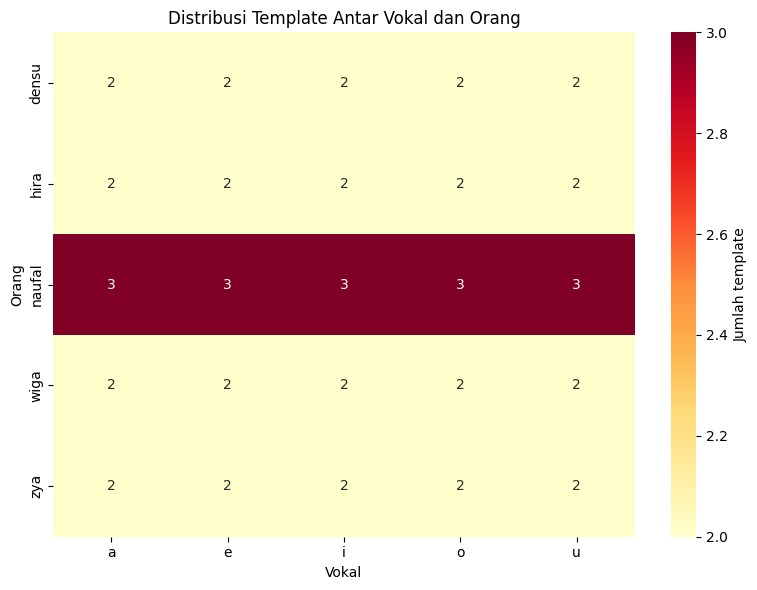


=== VISUALIZING GENERALIZED TEMPLATES ===
Generating template plot for vowel: a


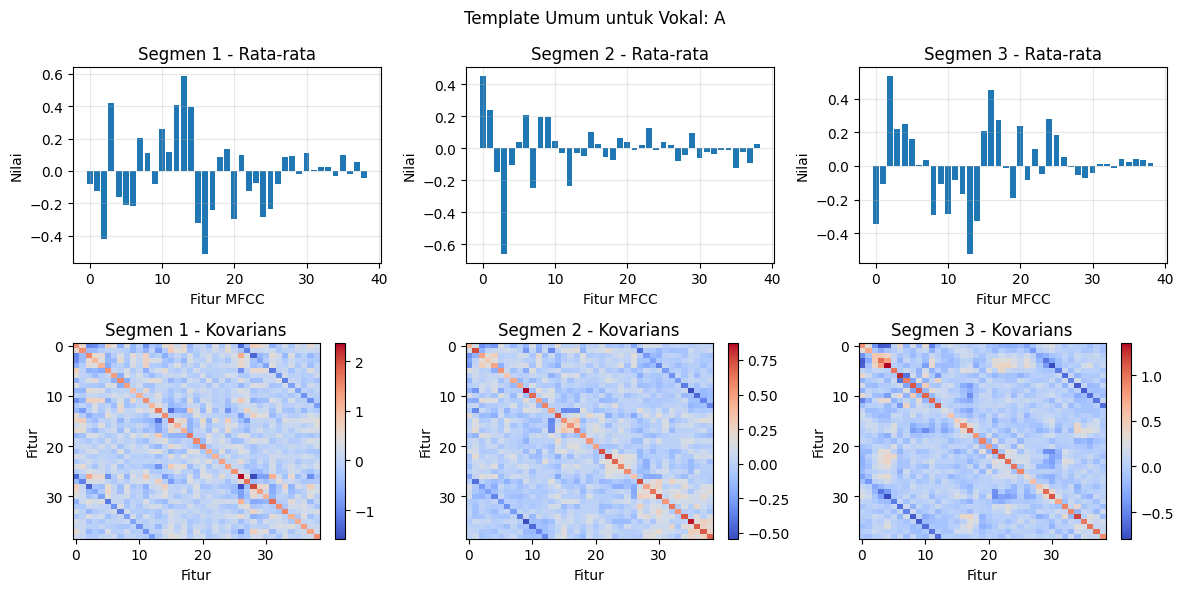

Generating template plot for vowel: i


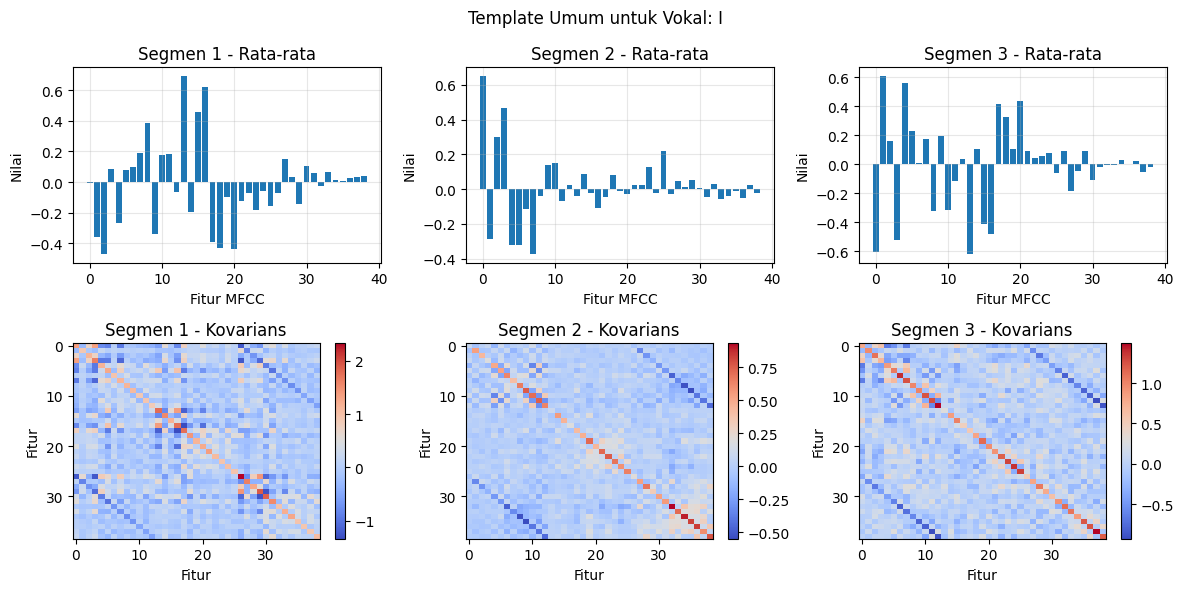

Generating template plot for vowel: u


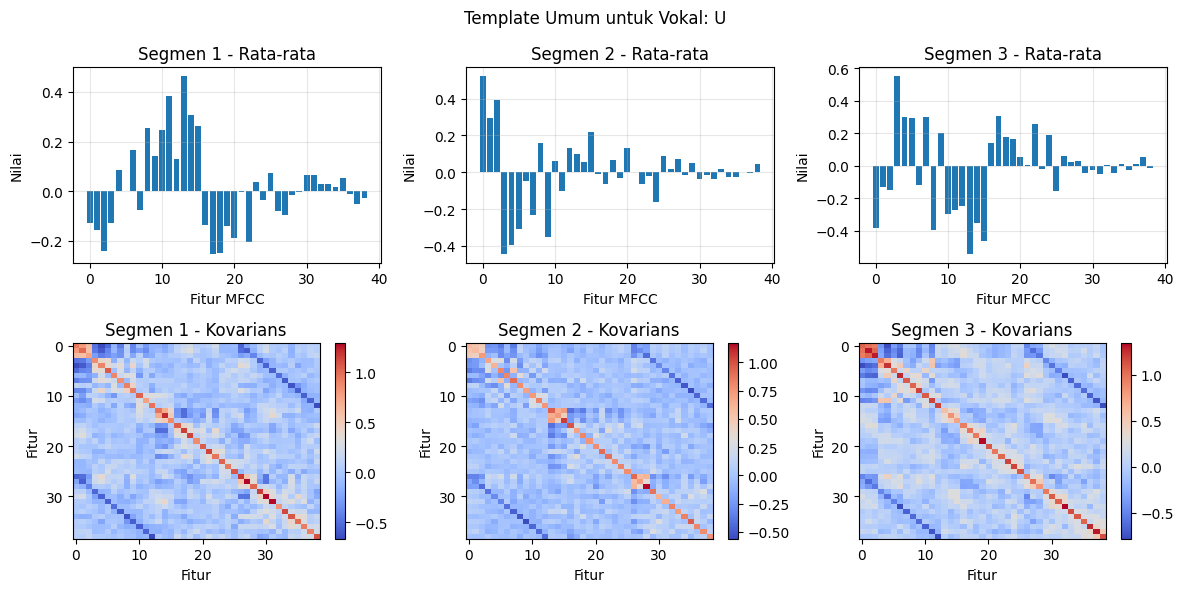

Generating template plot for vowel: e


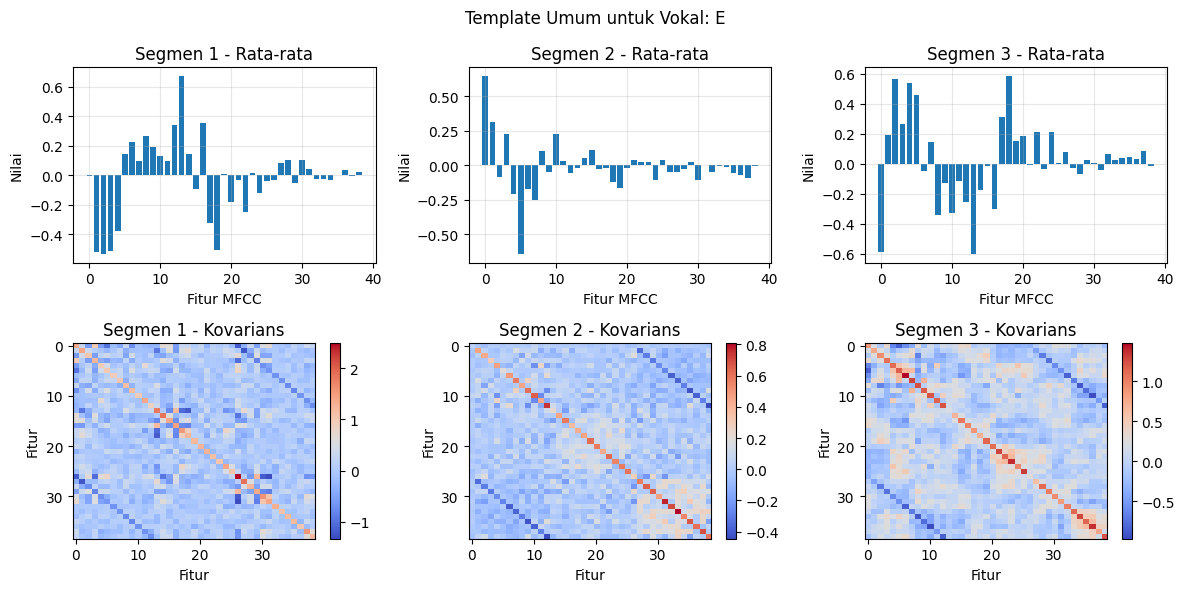

Generating template plot for vowel: o


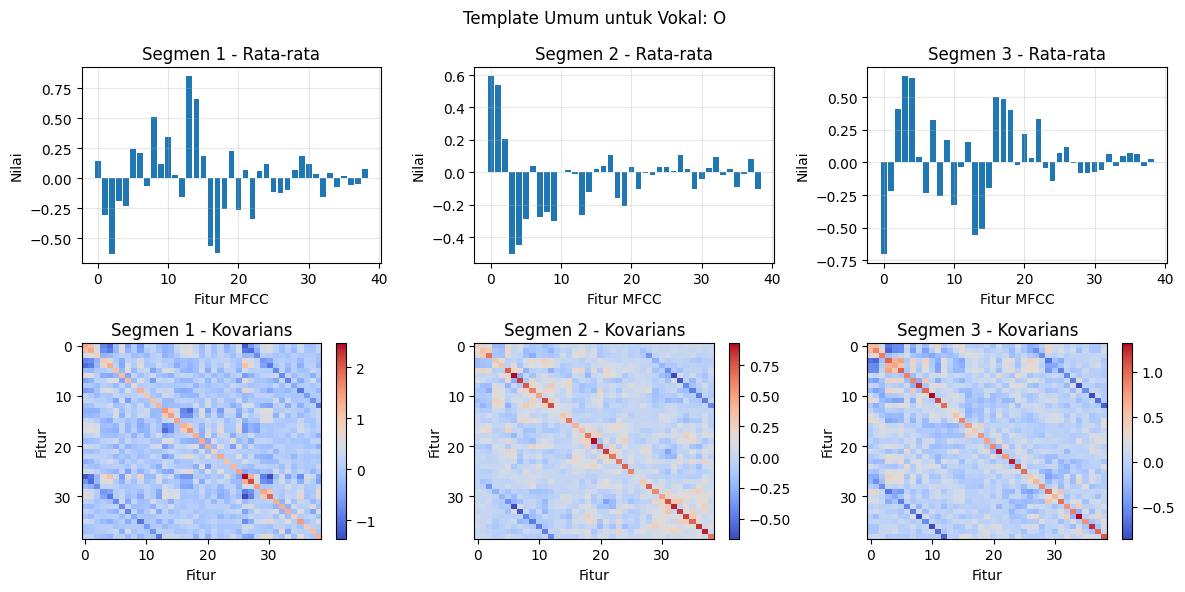


=== Sample 1/3 ===

--- Visualizing sample: densu - a 3 (closed) ---


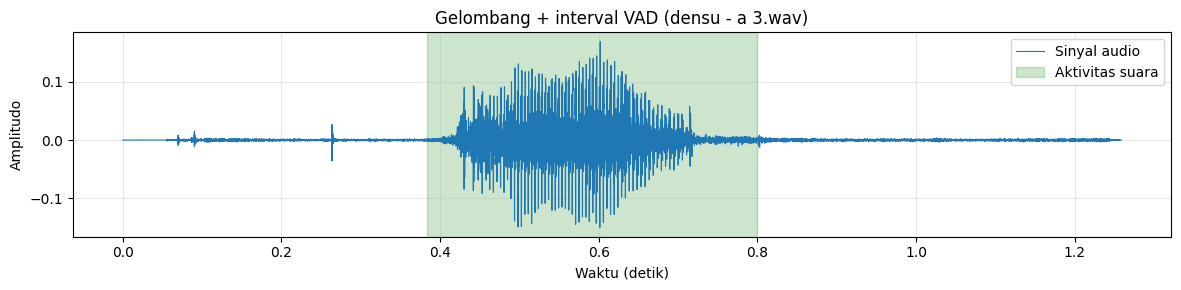

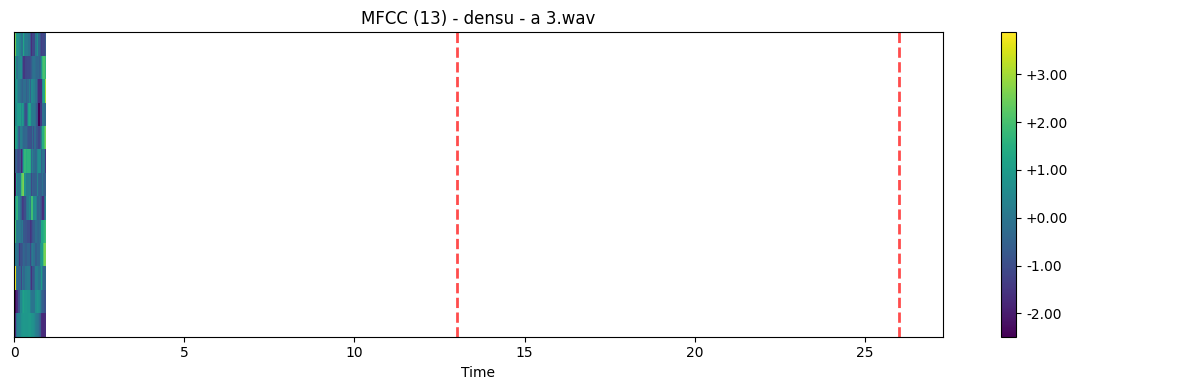

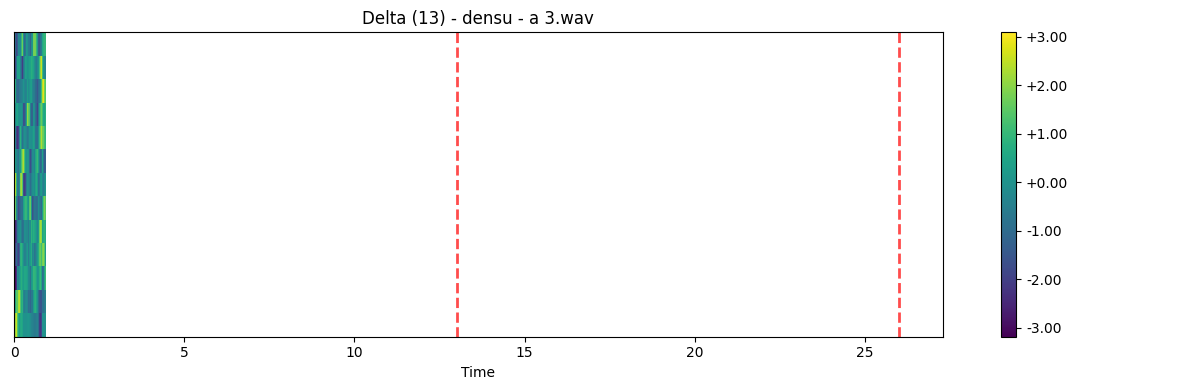

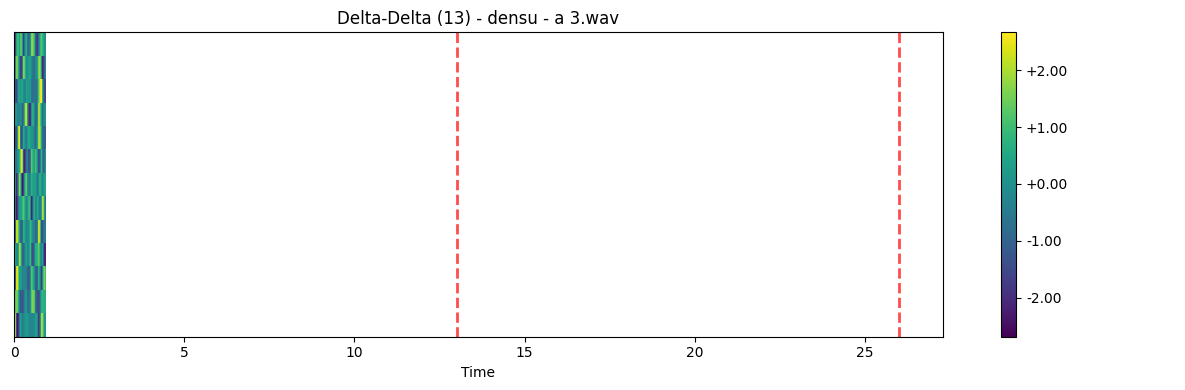

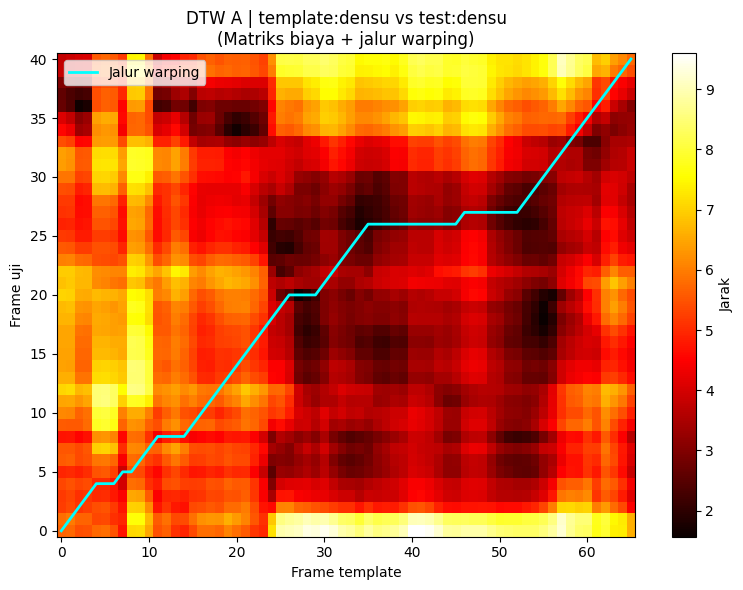

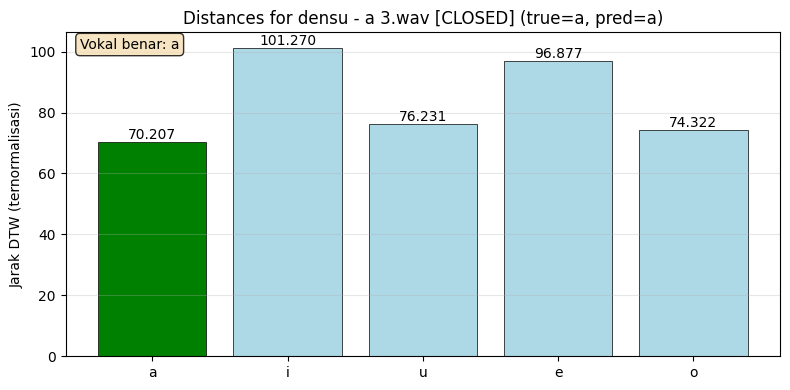

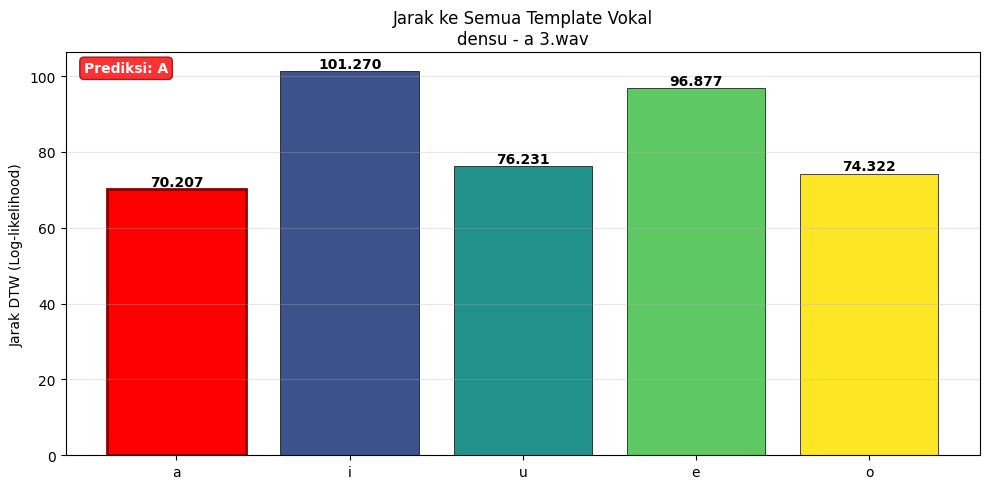

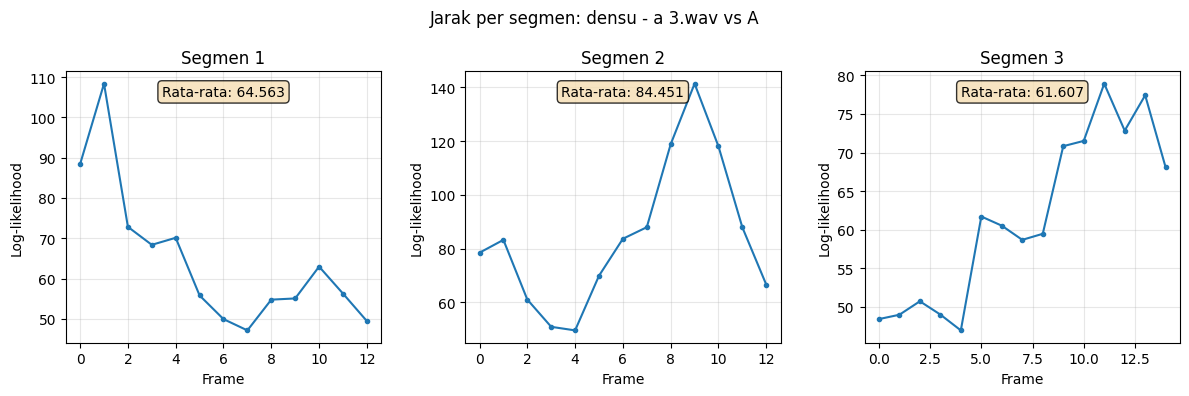


=== Sample 2/3 ===

--- Visualizing sample: densu - i 3 (closed) ---


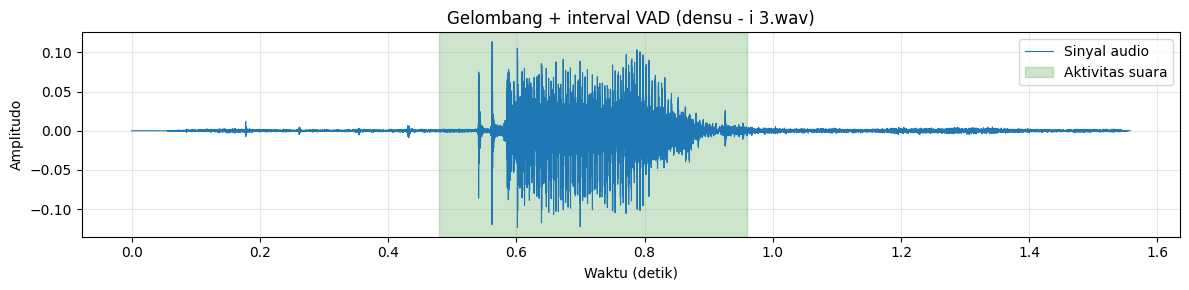

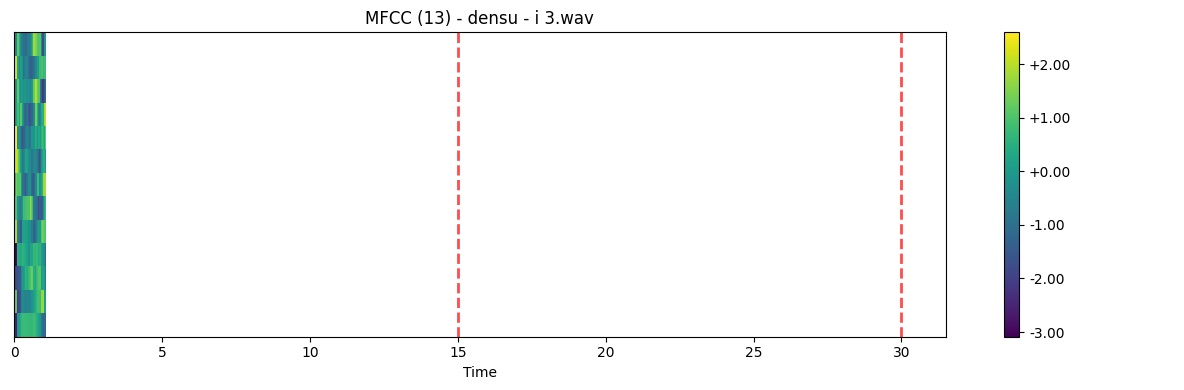

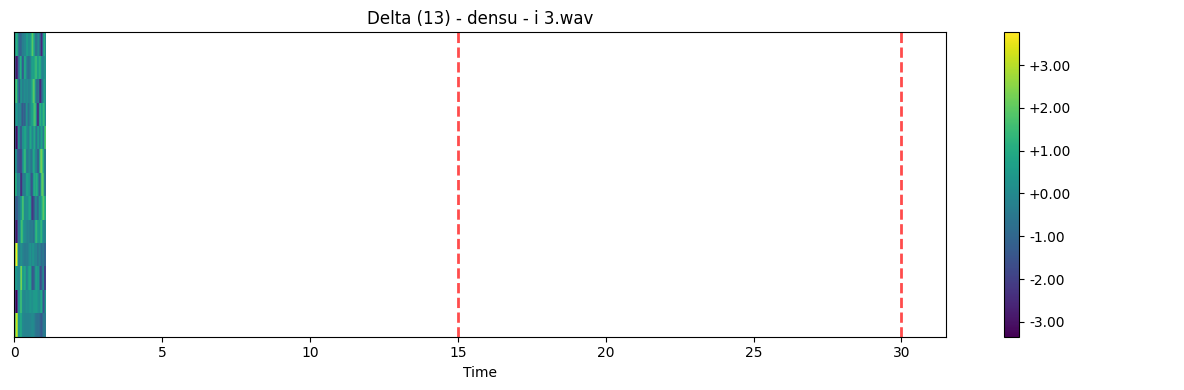

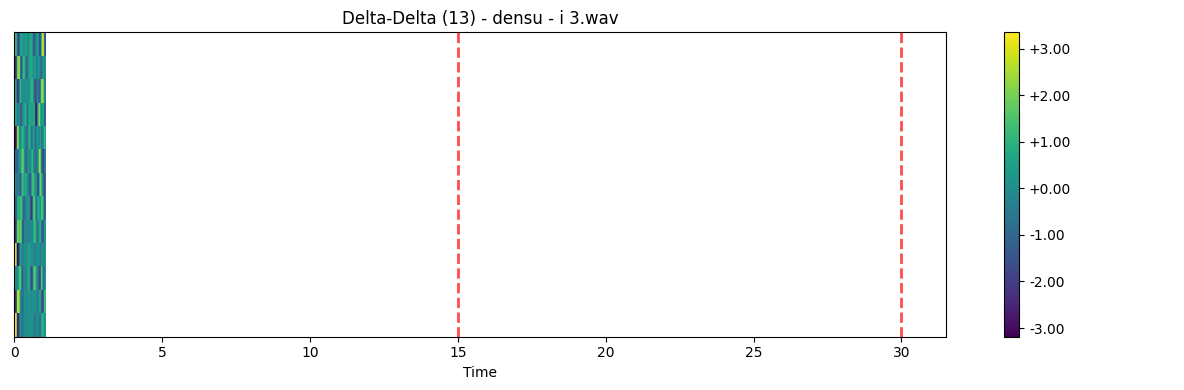

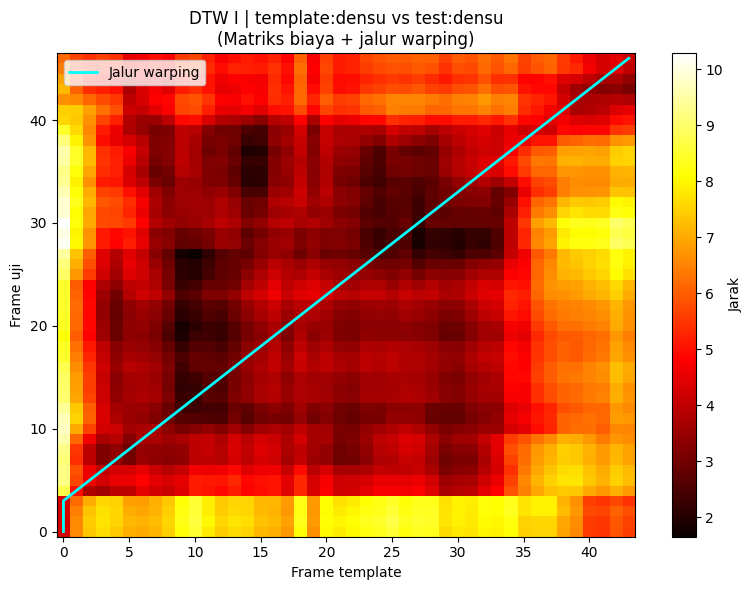

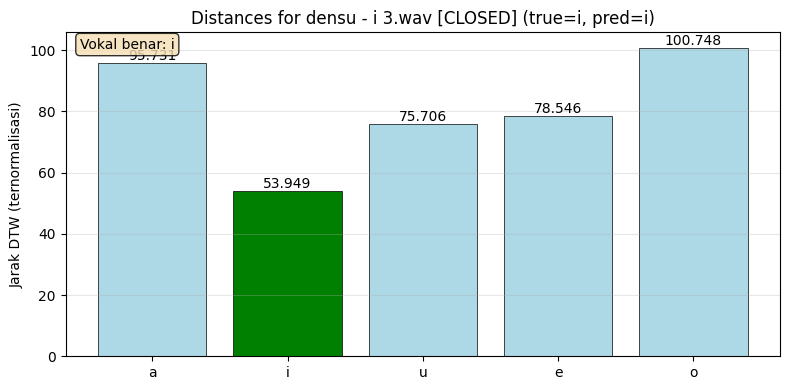

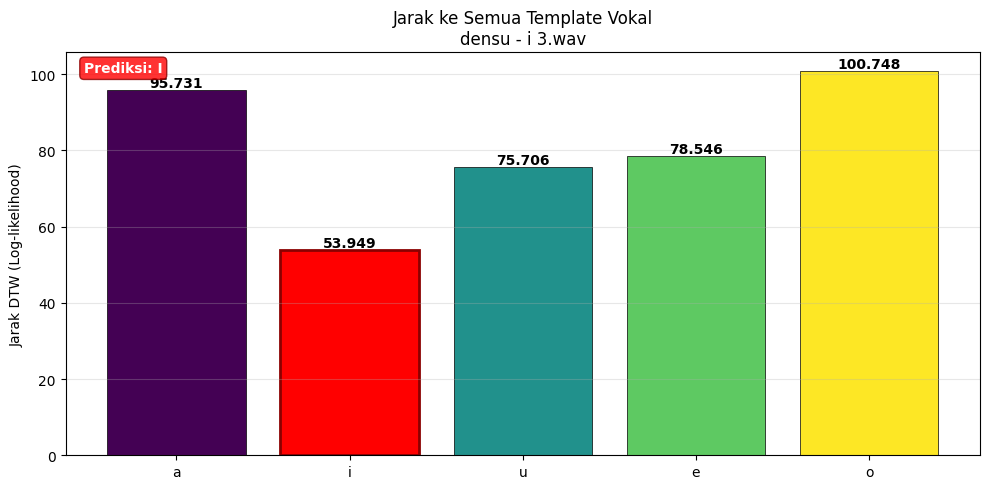

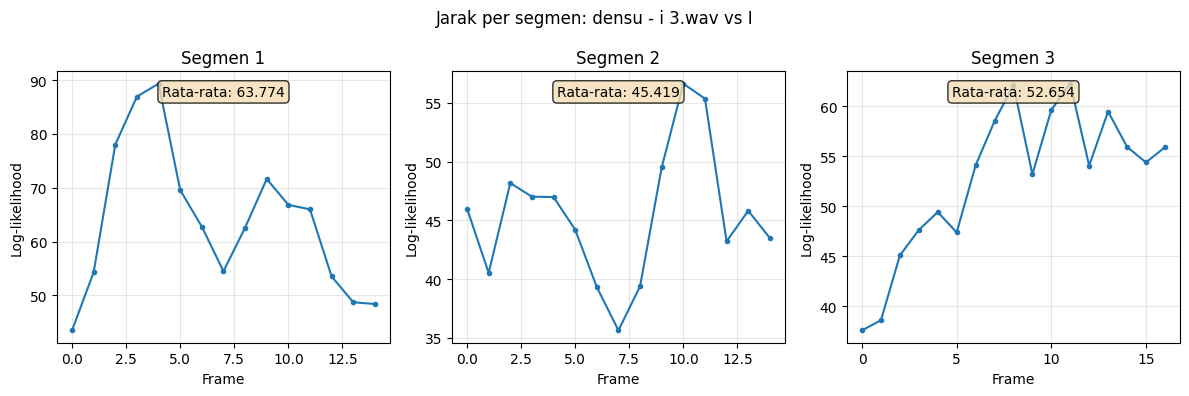


=== Sample 3/3 ===

--- Visualizing sample: densu - u 3 (closed) ---


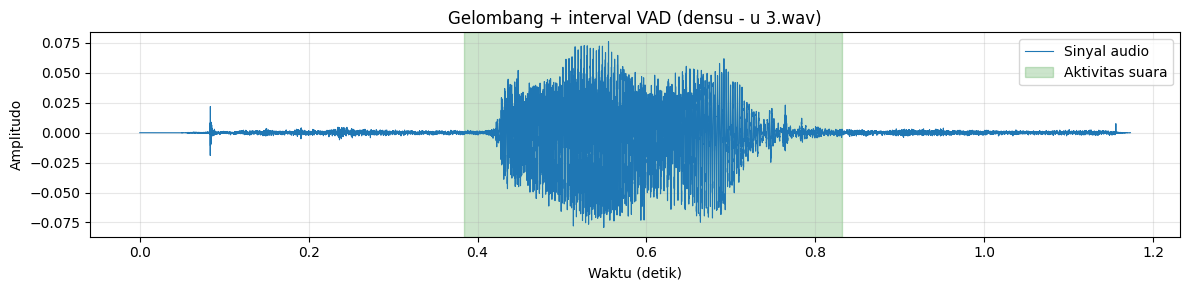

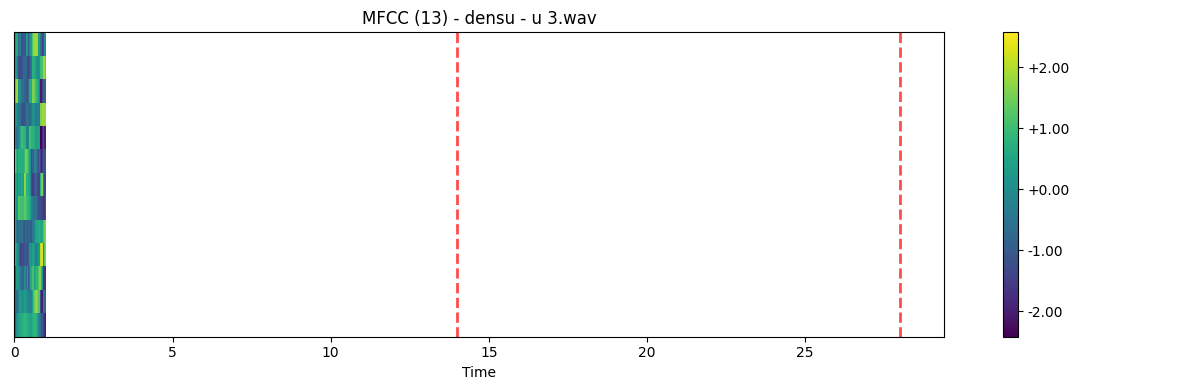

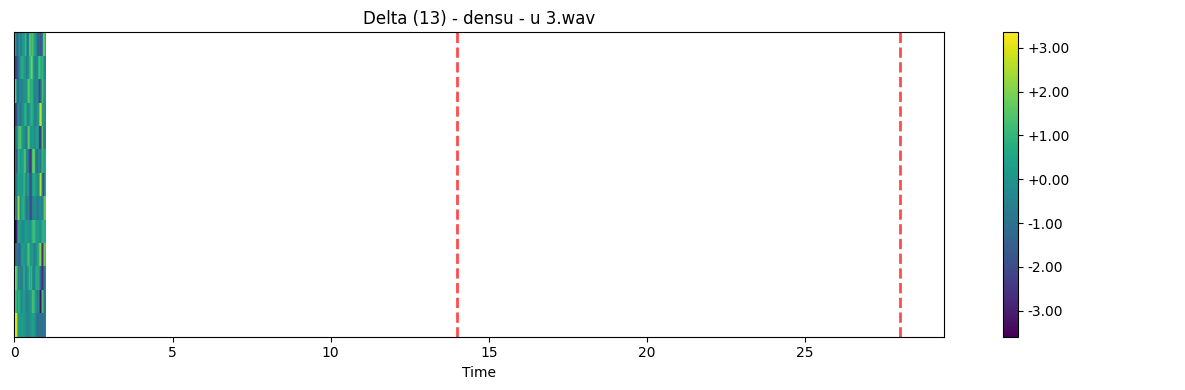

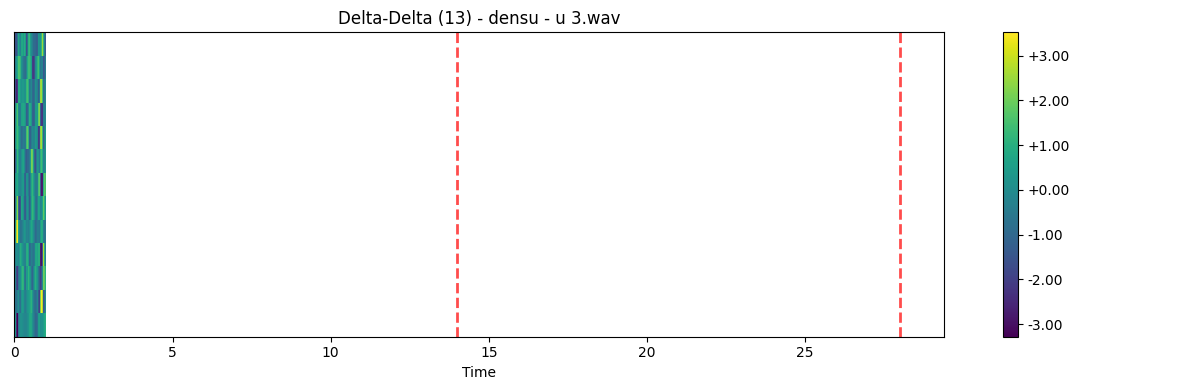

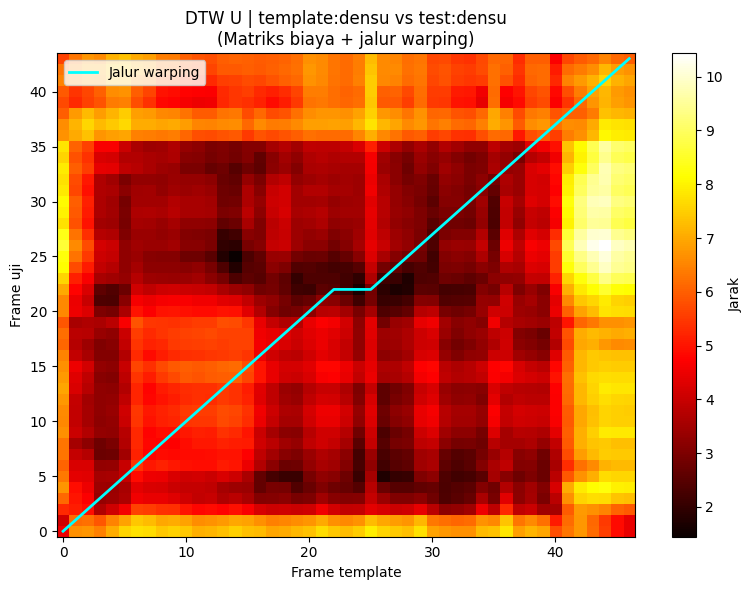

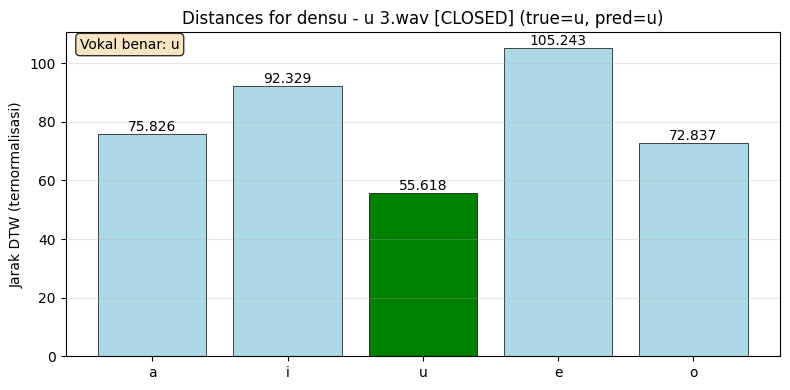

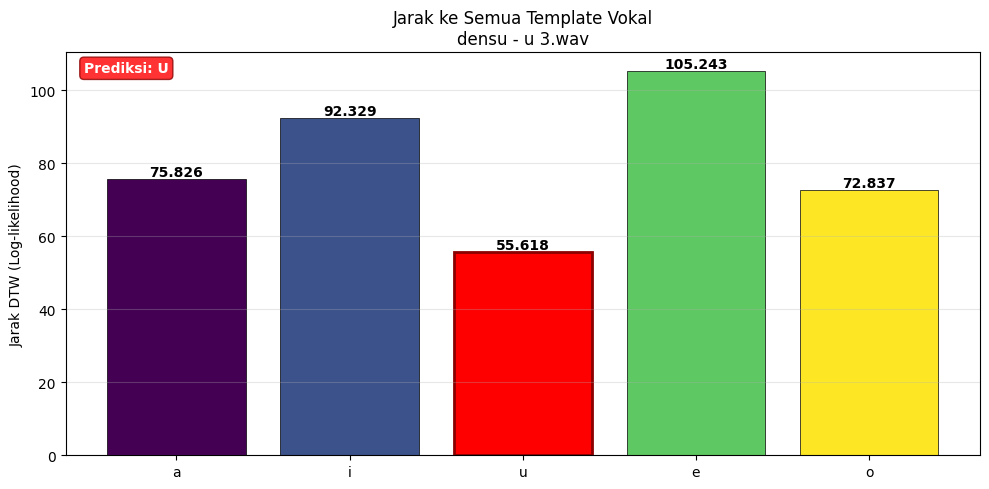

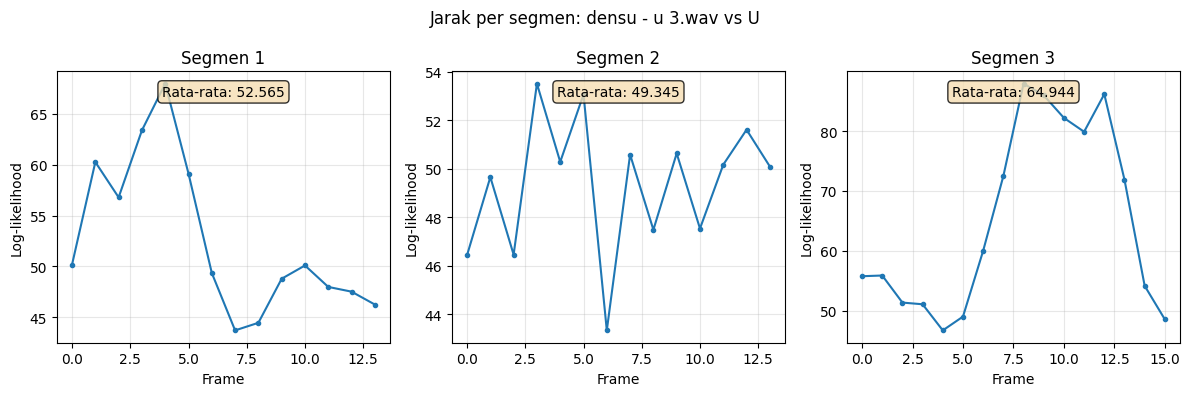


=== Sample 1/3 ===

--- Visualizing sample: dab - a 2 (open) ---


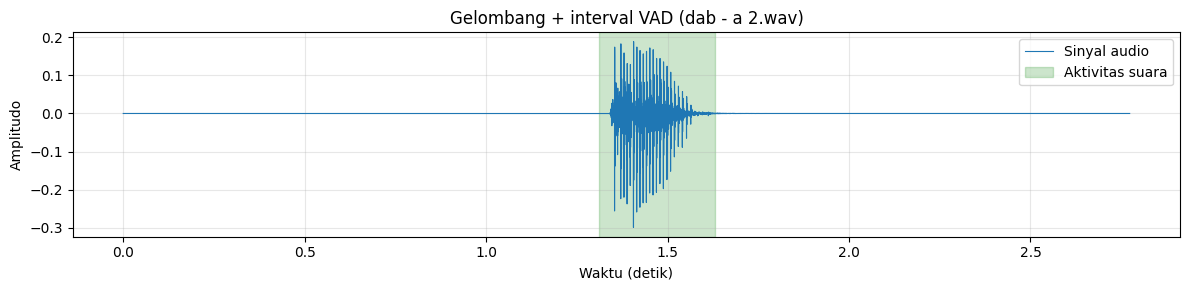

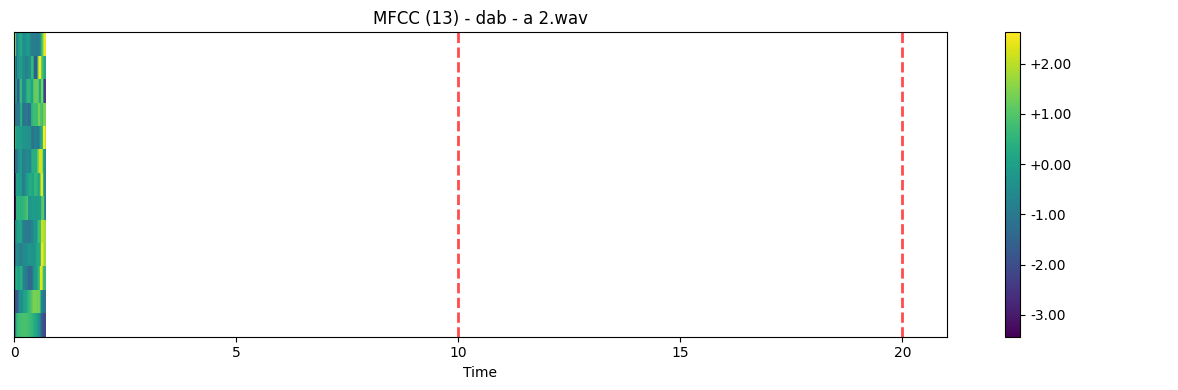

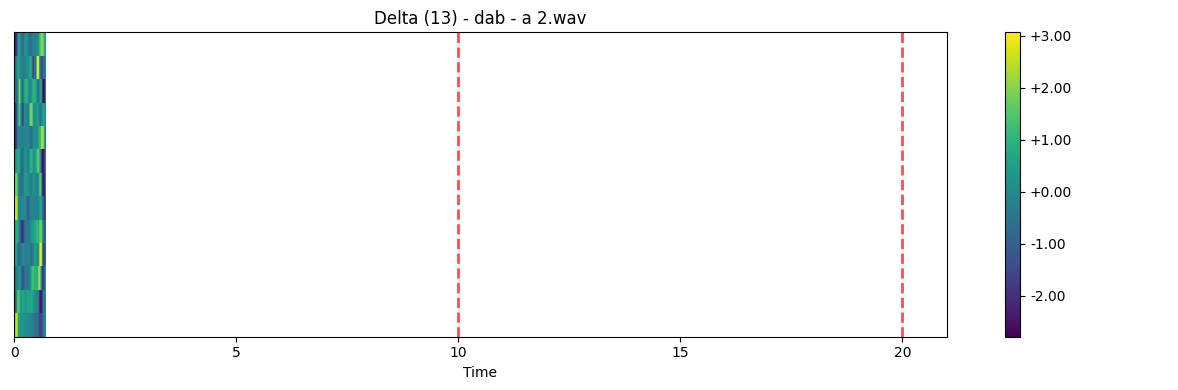

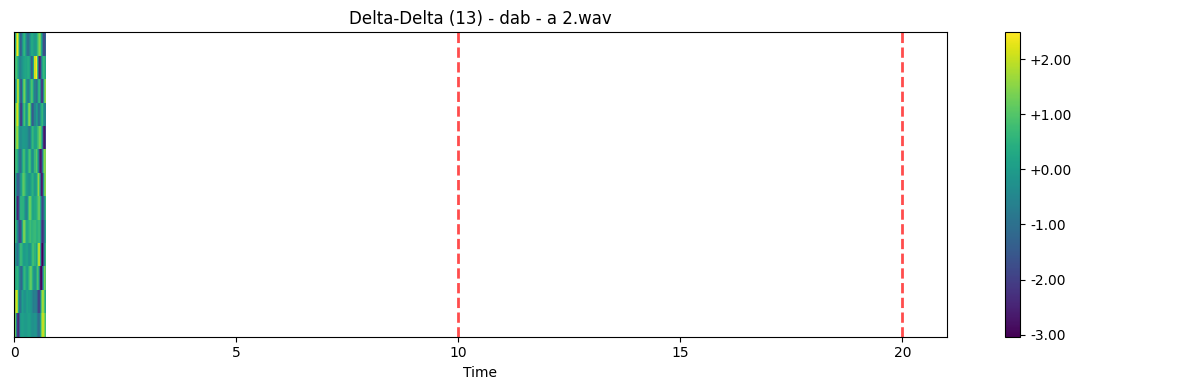

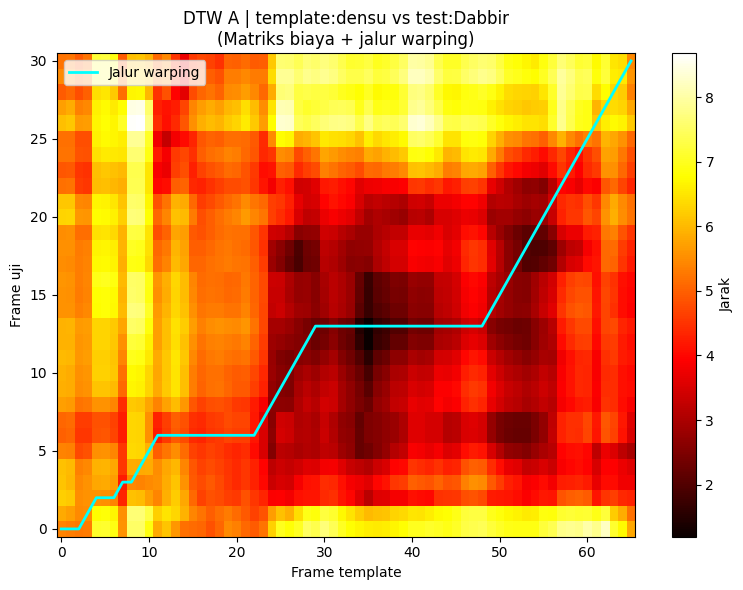

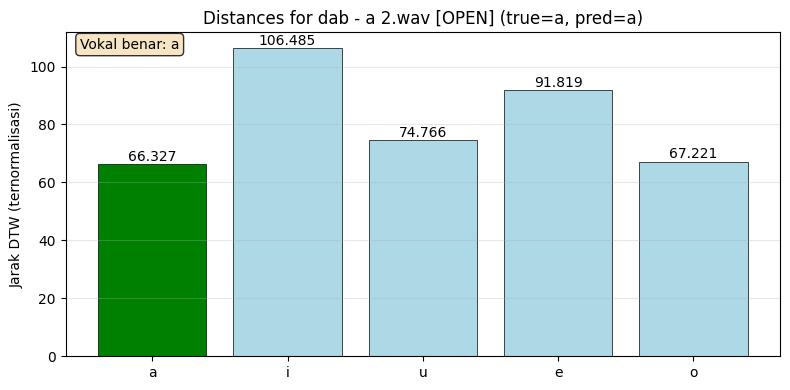

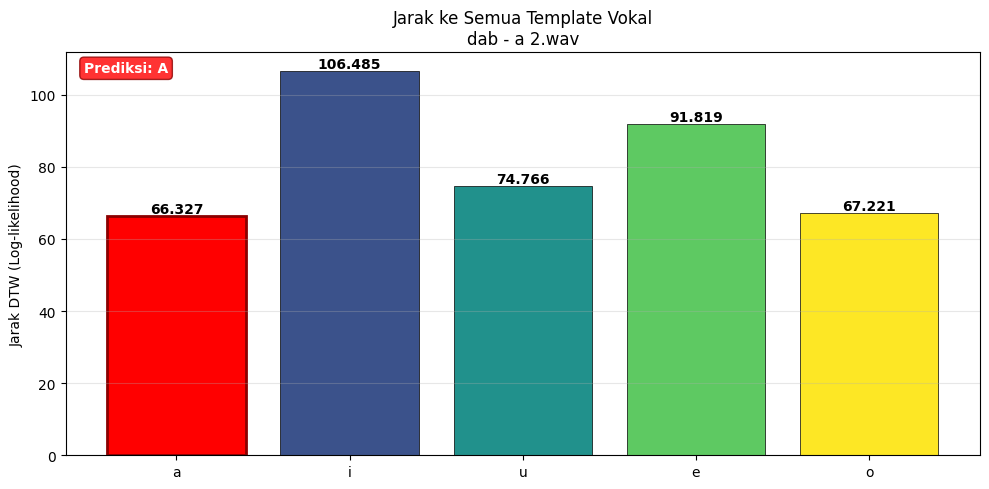

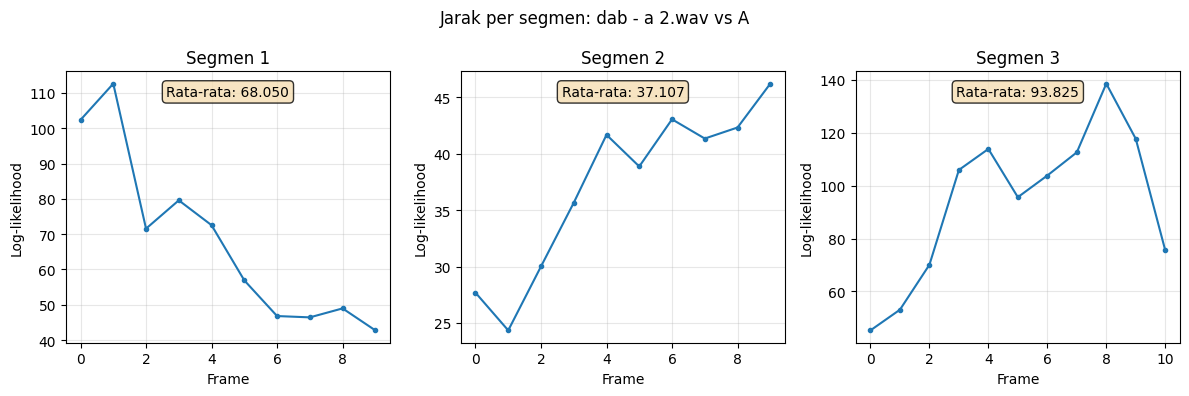


=== Sample 2/3 ===

--- Visualizing sample: dab - i 2 (open) ---


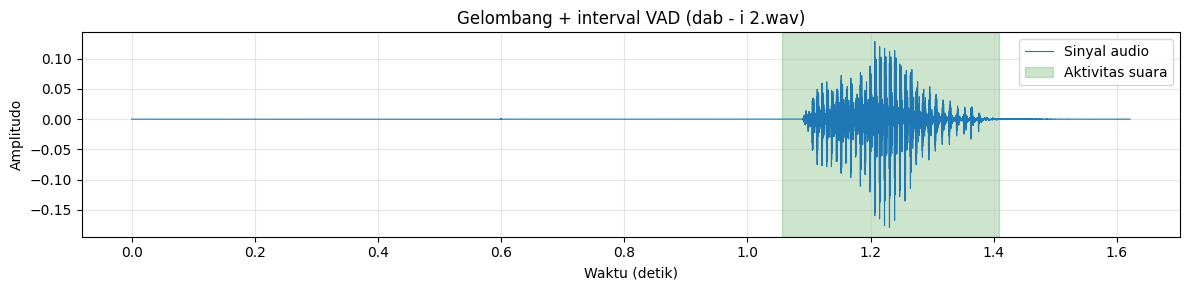

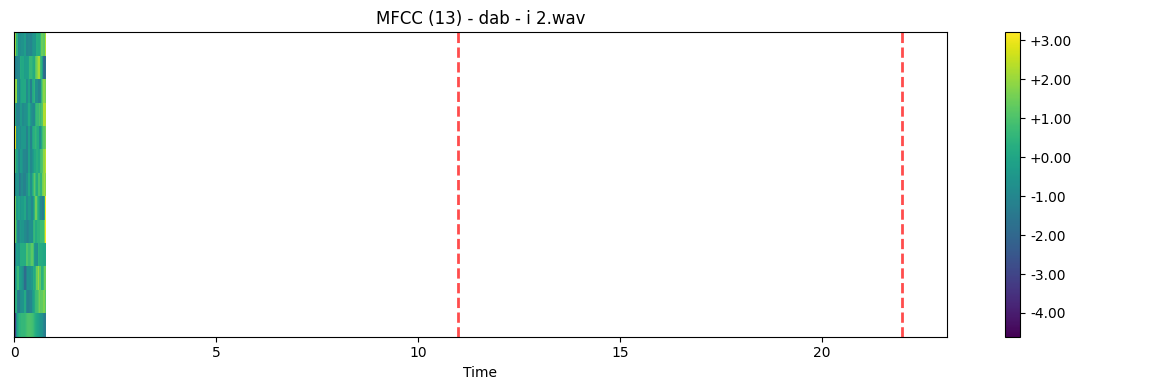

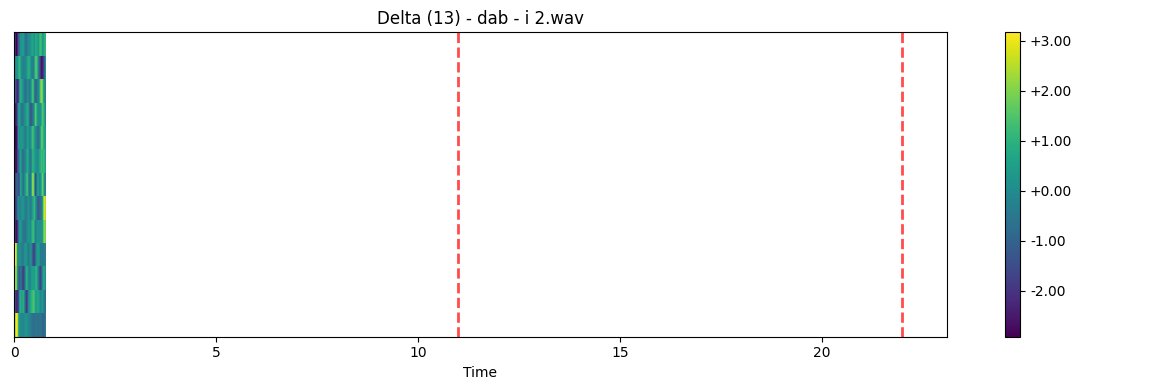

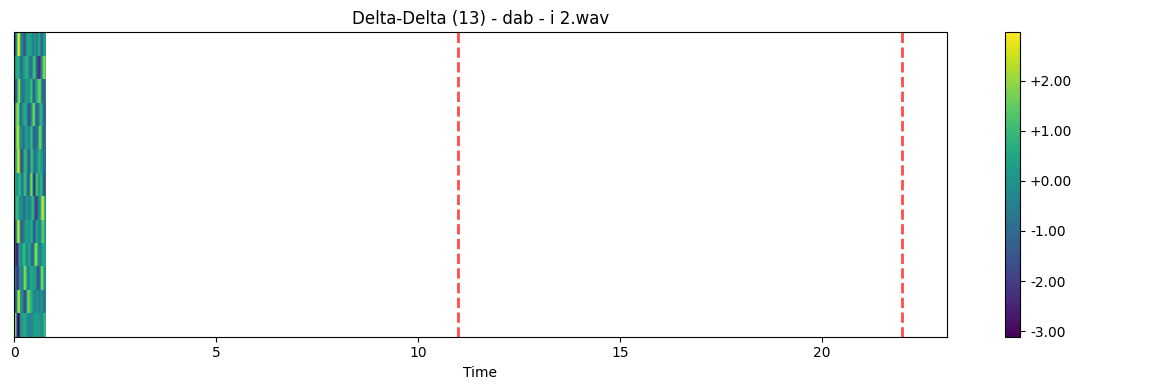

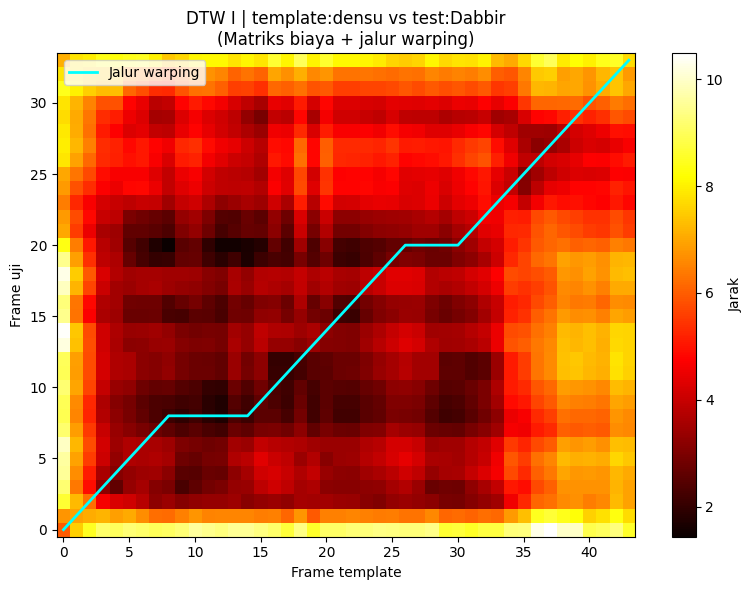

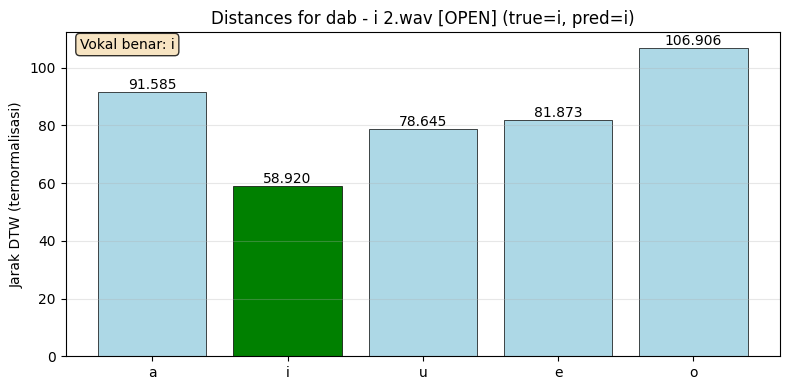

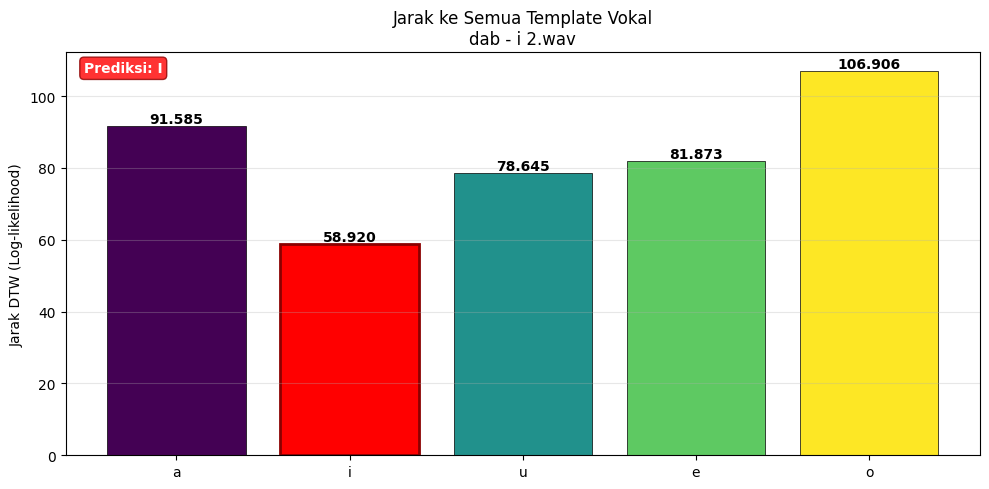

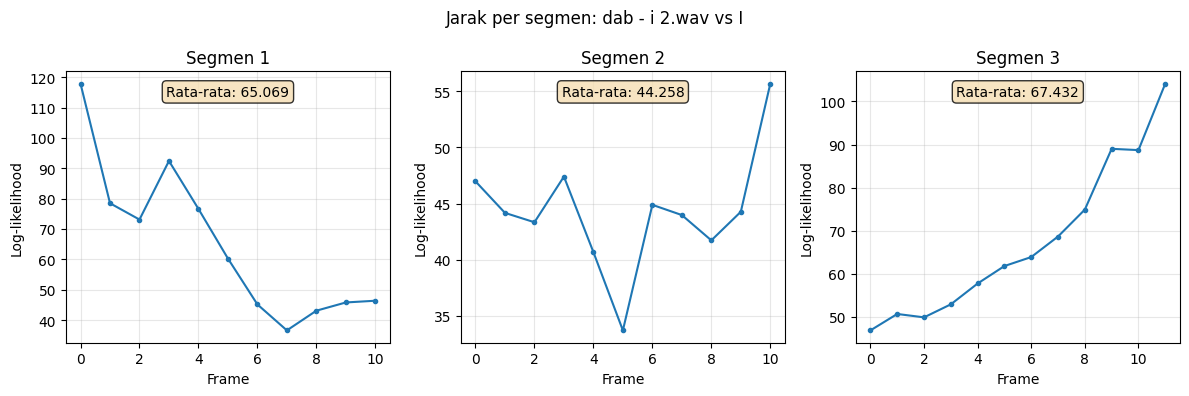


=== Sample 3/3 ===

--- Visualizing sample: dab - u 2 (open) ---


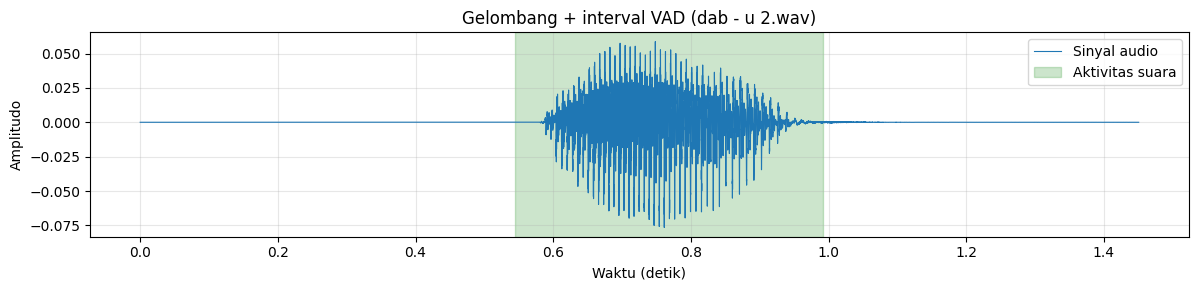

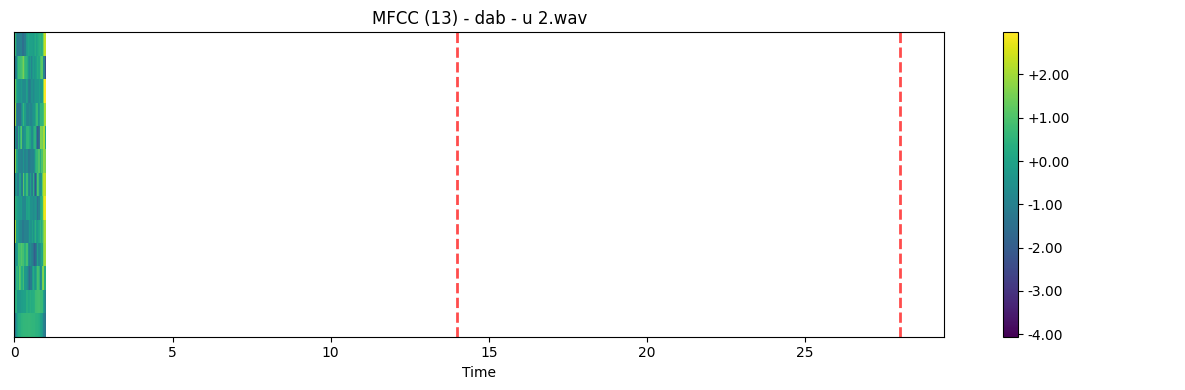

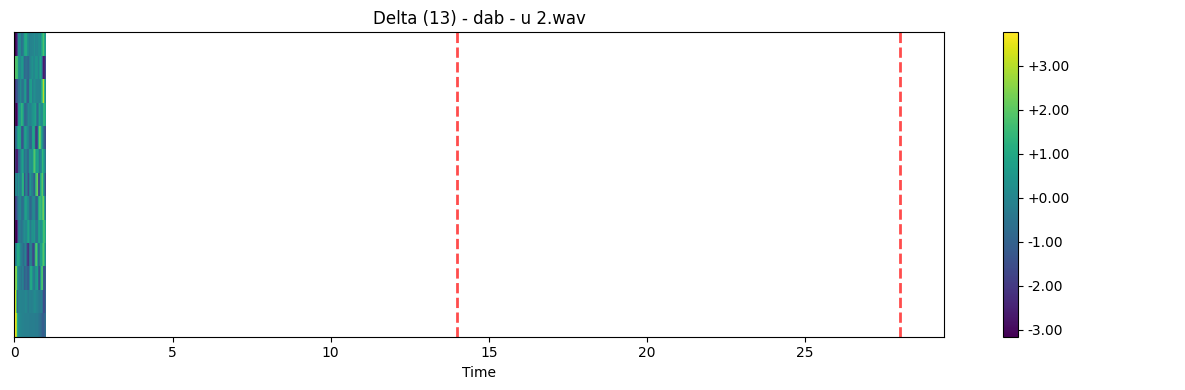

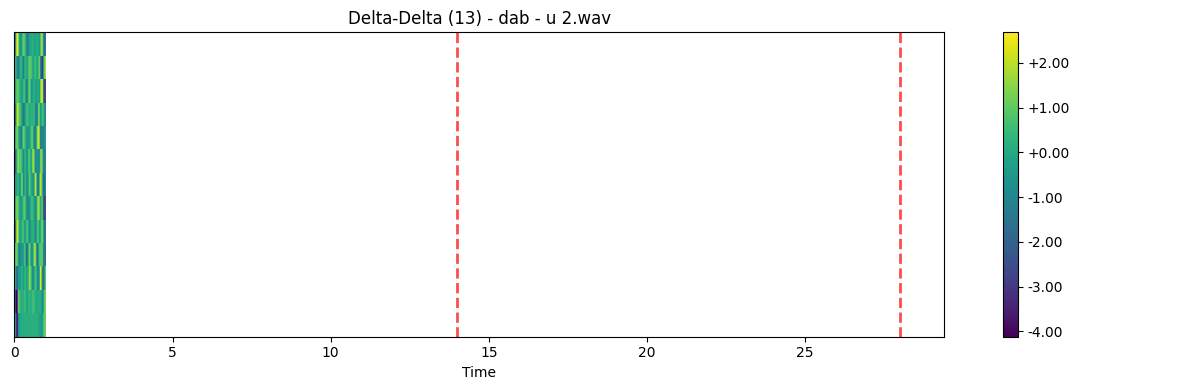

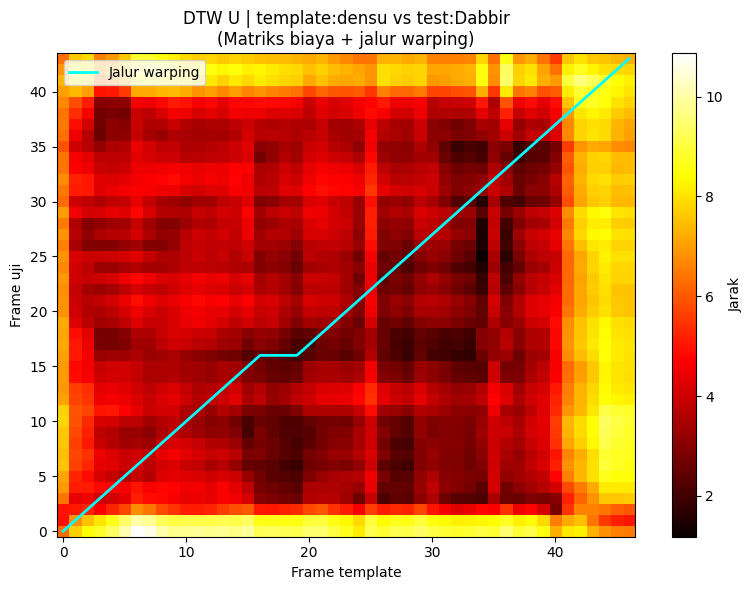

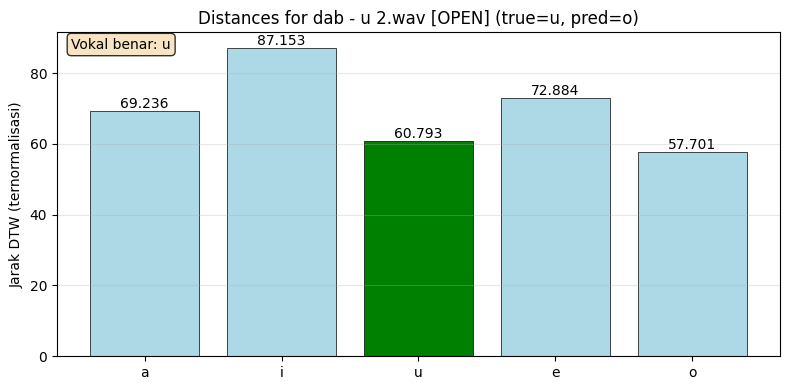

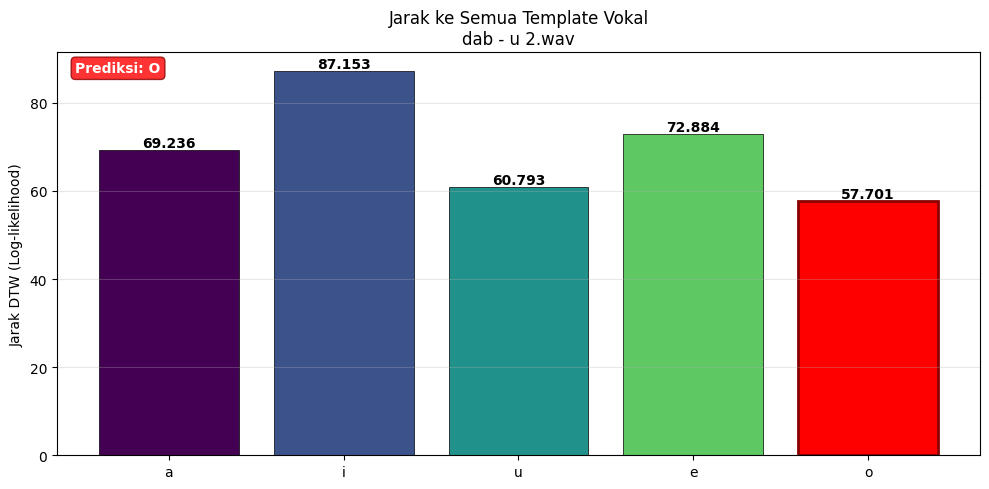

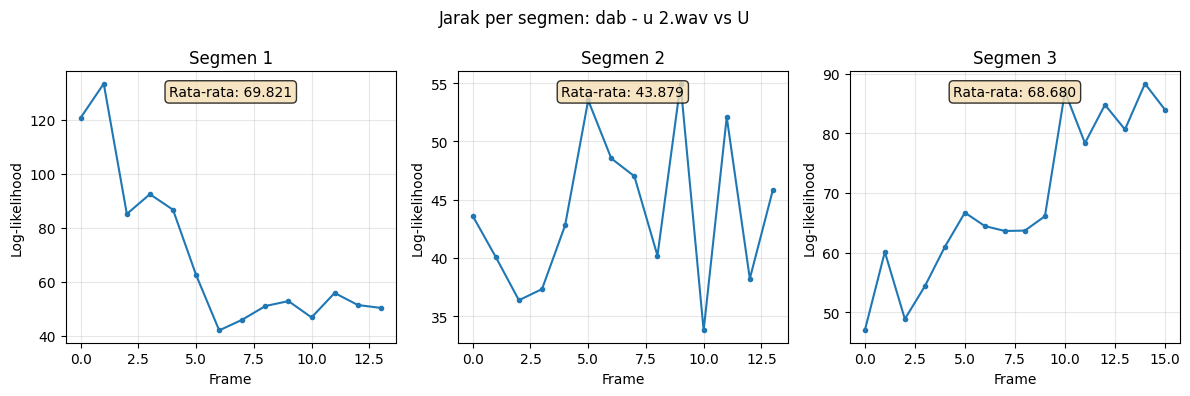


=== VISUALIZING EVALUATION RESULTS ===


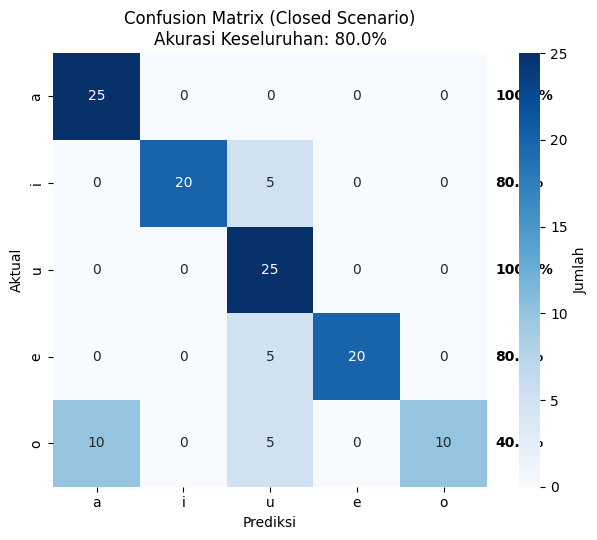

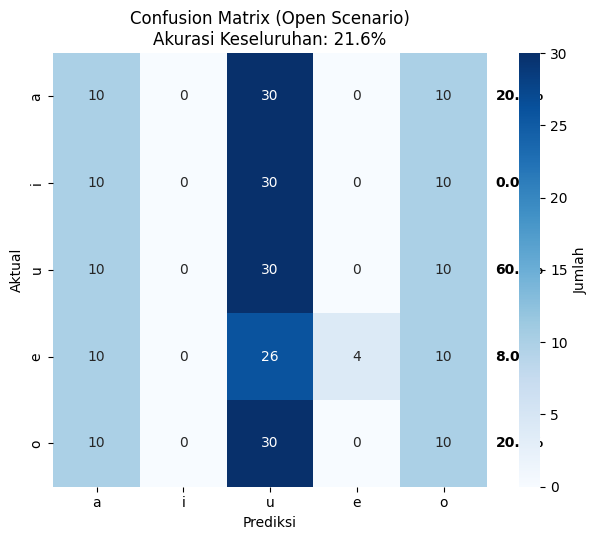


=== VISUALIZATION COMPLETE ===
All plots saved to: results/images


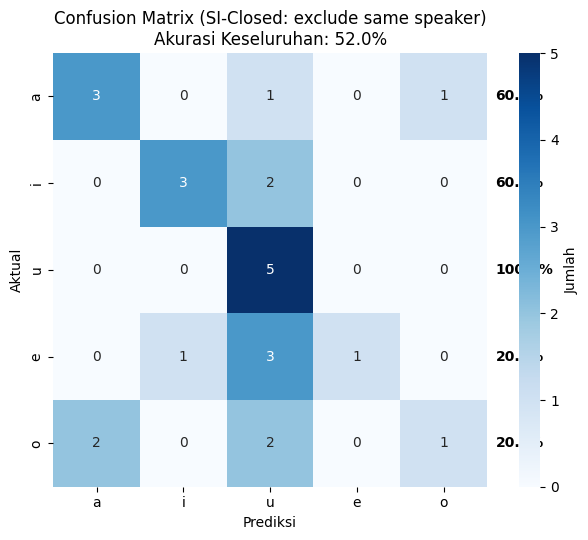


=== FINAL SUMMARY ===

Overall Results:
  Closed Accuracy:  80.00%
  Open Accuracy:    21.60%
  Average Accuracy: 50.80%
  SI-Closed Accuracy: 52.00%

Results saved to: results/
  - CSV predictions: predictions_closed.csv, predictions_open.csv
  - JSON summary: results.json
  - Visualizations: results/images/

Experiment completed successfully!


: 

In [ ]:
import os
import json
from typing import List, Optional


# Configuration
class Config:    
    # Paths
    BASE_PATH = ""
    TEMPLATES_US_PATH = "templates_us"
    TEMPLATES_OTHER_PATH = "templates_other"
    RESULTS_DIR = "results"
    IMAGES_DIR = os.path.join(RESULTS_DIR, "images")
    
    # Experiment settings
    PERSONS = ['densu', 'hira', 'naufal', 'wiga', 'zya']
    VOWELS = ['a', 'i', 'u', 'e', 'o']
    
    # Recognizer parameters
    SAMPLE_RATE = 16000
    USE_VAD = True
    NORMALIZE = True
    N_SEGMENTS = 3
    MAX_TEMPLATES_PER_SPEAKER: Optional[int] = None  # None = use all available
    
    # Visualization settings
    MAX_SAMPLES_PER_SCENARIO = 3
    
    def __init__(self):
        # Ensure directories exist
        os.makedirs(self.RESULTS_DIR, exist_ok=True)
        os.makedirs(self.IMAGES_DIR, exist_ok=True)
    
    @property
    def templates_us_full_path(self):
        return os.path.join(self.BASE_PATH, self.TEMPLATES_US_PATH)
    
    @property
    def templates_other_full_path(self):
        return os.path.join(self.BASE_PATH, self.TEMPLATES_OTHER_PATH)


def run_diagnostics(config: Config):
    """Run diagnostic checks on the directory structure"""
    print("=" * 60)
    print("=== RUNNING DIAGNOSTICS ===")
    print("=" * 60)
    
    print(f"\n--- Checking templates_us directory ---")
    diagnose_templates_dir(config.templates_us_full_path)
    
    if os.path.exists(config.templates_other_full_path):
        print(f"\n--- Checking templates_other directory ---")
        diagnose_templates_dir(config.templates_other_full_path)
    else:
        print(f"\n--- templates_other directory not found: {config.templates_other_full_path} ---")


def build_recognizer(config: Config):
    """Build the recognizer with templates"""
    print("\n" + "=" * 60)
    print("=== BUILDING RECOGNIZER ===")
    print("=" * 60)
    
    # Use the builder to create recognizer
    recognizer, test_data_templates, test_data_others = build_recognizer_from_folders(
        template_base_path=config.templates_us_full_path,
        template_persons=config.PERSONS,
        test_base_path=config.templates_other_full_path,
        sample_rate=config.SAMPLE_RATE,
        use_vad=config.USE_VAD,
        normalize=config.NORMALIZE,
        n_segments=config.N_SEGMENTS,
        max_templates_per_speaker=config.MAX_TEMPLATES_PER_SPEAKER
    )
    
    return recognizer, test_data_templates, test_data_others


def run_evaluation(recognizer, test_data_templates, test_data_others, config: Config):
    """Run comprehensive evaluation"""
    print("\n" + "=" * 60)
    print("=== RUNNING EVALUATION ===")
    print("=" * 60)
    
    # Main evaluation using recognizer's built-in method
    results_summary = recognizer.evaluate_all_scenarios(test_data_templates, test_data_others)
    
    # Additional SI-Closed evaluation
    print(f"\n--- SI-Closed Evaluation ---")
    si_closed_acc, si_closed_results = evaluate_si_closed(recognizer, test_data_templates)
    print(f"SI-Closed Accuracy: {si_closed_acc:.2f}%")
    
    # Add SI-Closed results to summary
    results_summary['si_closed'] = {
        'si_closed_accuracy': si_closed_acc,
        'si_closed_results': si_closed_results
    }
    
    return results_summary


def export_results(recognizer, test_data_templates, test_data_others, results_summary, config: Config):
    """Export results to CSV and JSON"""
    print("\n" + "=" * 60)
    print("=== EXPORTING RESULTS ===")
    print("=" * 60)
    
    # Export prediction CSVs
    if test_data_templates:
        csv_path_closed = os.path.join(config.RESULTS_DIR, "predictions_closed.csv")
        export_predictions_csv(recognizer, test_data_templates, csv_path_closed)
        print(f"Closed predictions saved to: {csv_path_closed}")
    
    if test_data_others:
        csv_path_open = os.path.join(config.RESULTS_DIR, "predictions_open.csv")
        export_predictions_csv(recognizer, test_data_others, csv_path_open)
        print(f"Open predictions saved to: {csv_path_open}")
    
    # Export JSON summary
    json_path = os.path.join(config.RESULTS_DIR, 'results.json')
    json_results = {}
    
    for k, v in results_summary.items():
        if k == 'overall':
            json_results[k] = v
        elif k == 'si_closed':
            json_results[k] = {'si_closed_accuracy': v.get('si_closed_accuracy')}
        else:
            if isinstance(v, dict):
                json_results[k] = {
                    'closed_accuracy': v.get('closed_accuracy'),
                    'open_accuracy': v.get('open_accuracy'),
                    'average_accuracy': v.get('average_accuracy')
                }
    
    with open(json_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    
    print(f"Results summary saved to: {json_path}")


def create_visualizations(recognizer, test_data_templates, test_data_others, results_summary, config: Config):
    """Create comprehensive visualizations"""
    print("\n" + "=" * 60)
    print("=== CREATING VISUALIZATIONS ===")
    print("=" * 60)
    
    visualization_summary = create_comprehensive_visualizations(
        recognizer=recognizer,
        test_data_templates=test_data_templates,
        test_data_others=test_data_others,
        results_summary=results_summary,
        images_dir=config.IMAGES_DIR,
        max_samples_per_scenario=config.MAX_SAMPLES_PER_SCENARIO
    )
    
    # Additional confusion matrix for SI-Closed if available
    if 'si_closed' in results_summary and 'si_closed_results' in results_summary['si_closed']:
        visualizer = SafeVisualizer(recognizer, config.IMAGES_DIR)
        si_results = results_summary['si_closed']['si_closed_results']
        if si_results:
            visualizer.safe_plot_confusion_heatmap(
                si_results,
                title="Confusion Matrix (SI-Closed: exclude same speaker)",
                save_path=os.path.join(config.IMAGES_DIR, "confusion_matrix_si_closed.png")
            )
    
    return visualization_summary


def print_final_summary(results_summary, config: Config):
    """Print final summary of results"""
    print("\n" + "=" * 80)
    print("=== FINAL SUMMARY ===")
    print("=" * 80)
    
    if 'overall' in results_summary:
        overall = results_summary['overall']
        print(f"\nOverall Results:")
        print(f"  Closed Accuracy:  {overall.get('closed_accuracy', 0):.2f}%")
        print(f"  Open Accuracy:    {overall.get('open_accuracy', 0):.2f}%")
        print(f"  Average Accuracy: {overall.get('average_accuracy', 0):.2f}%")
    
    if 'si_closed' in results_summary:
        si_acc = results_summary['si_closed'].get('si_closed_accuracy', 0)
        print(f"  SI-Closed Accuracy: {si_acc:.2f}%")
    
    print(f"\nResults saved to: {config.RESULTS_DIR}/")
    print(f"  - CSV predictions: predictions_closed.csv, predictions_open.csv")
    print(f"  - JSON summary: results.json")
    print(f"  - Visualizations: {config.IMAGES_DIR}/")
    
    print(f"\nExperiment completed successfully!")


def main():
    """Main execution function"""
    print("Starting Vowel Recognition System Evaluation")
    print("=" * 80)
    
    # Initialize configuration
    config = Config()
    
    try:
        # Step 1: Run diagnostics
        run_diagnostics(config)
        
        # Step 2: Build recognizer
        recognizer, test_data_templates, test_data_others = build_recognizer(config)
        
        # Step 3: Run evaluation
        results_summary = run_evaluation(recognizer, test_data_templates, test_data_others, config)
        
        # Step 4: Export results
        export_results(recognizer, test_data_templates, test_data_others, results_summary, config)
        
        # Step 5: Create visualizations
        visualization_summary = create_visualizations(
            recognizer, test_data_templates, test_data_others, results_summary, config
        )
        
        # Step 6: Print final summary
        print_final_summary(results_summary, config)
        
    except Exception as e:
        print(f"\nERROR: Experiment failed with exception:")
        print(f"  {type(e).__name__}: {e}")
        print(f"\nCheck your data paths and file structure.")
        return False
    
    return True


if __name__ == "__main__":
    success = main()
    exit(0 if success else 1)